In [1]:
# # load dataset

# from datasets import load_dataset
# from tokenizers import ByteLevelBPETokenizer

# tokenizer = ByteLevelBPETokenizer()
# dataset = load_dataset("roneneldan/TinyStories")

# # Specify the split you want to save (e.g., "train", "validation", "test")
# split = "train"

# # Get the desired split from the dataset
# subset = dataset[split]

# # Save the subset to a text file
# subset.to_csv("tinystories-train.txt", sep="\t", index=False)


In [2]:
#----- imports --------

import tqdm
import torch
from torch import nn
import wandb
import os
import tokenizers
from matplotlib import pyplot as plt
import numpy as np
import json


device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"

config = {
    "learning_rate": 1e-3,
    "sae_learning_rate": 5e-5,
    "model_embedding_layer": 6,
    "eval_interval": 500,
    "max_iters": 60000, 
    "H": 32, # hidden dimension size
    "B": 64,
    "T": 256,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 8,
    "n_layers": 12,
    "tokenizer_vocab_size": 2**13,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v


#wandb.init(
#    project = "tinystories",
#    config = config,
#)

In [3]:

# stories_data = []
# data_dir = './data'
# for filename in os.listdir(data_dir):
#     file_path = os.path.join(data_dir, filename)
#     if filename.endswith('.json'):
#         with open(file_path, 'r', encoding='utf-8') as f:
#             data = json.load(f)
#             stories_data.extend(data)






In [4]:
# # load the tinystories tokenizer
# tokenizer = tokenizers.ByteLevelBPETokenizer(
#     "./tiny-stories-bpe-vocab.json", 
#     "./tiny-stories-bpe-merges.txt"
# )



# def encode(text):
#     return torch.tensor(tokenizer.encode(text).ids, dtype=torch.int64)
# def decode(encoded_text):
#     return tokenizer.decode(encoded_text.tolist())

# from tqdm import tqdm

# encoded_stories = [encode(story['story']) for story in tqdm(stories_data, desc="Encoding stories")]



In [5]:
# # save the encoded stories to a file
# torch.save(encoded_stories, 'encoded-stories.pt')

In [6]:

with open('tinystories-train.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [7]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1916206969


In [8]:
1916206969/4

479051742.25

In [9]:
print("length of dataset in lines: ", len(text.split('\n')))

length of dataset in lines:  20550005


In [10]:
print(text[:1000])

text
"One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, ""Mom, I found this needle. Can you share it with me and sew my shirt?"" Her mom smiled and said, ""Yes, Lily, we can share the needle and fix your shirt.""

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together."
"Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that wer

In [11]:
# paths = ['tinystories-train.txt']
# tokenizer = tokenizers.ByteLevelBPETokenizer()

# tokenizer.train(files=paths, vocab_size=tokenizer_vocab_size, min_frequency=2)

# tokenizer.save_model('.', 'tiny-stories-bpe')



# enc = tokenizer.encode("She sells sea shells by the sea shore!")
# tokenizer.decode(enc.ids)



In [12]:
tokenizer = tokenizers.ByteLevelBPETokenizer(
    "./tiny-stories-bpe-vocab.json", 
    "./tiny-stories-bpe-merges.txt"
)


In [13]:

def encode(text):
    return tokenizer.encode(text).ids
def decode(encoded_text):
    return tokenizer.decode(encoded_text)

from tqdm import tqdm

def batch_encode(text, batch_size):
    tokens = []
    for i in tqdm(range(0, len(text), batch_size)):
        tokens.extend(encode(text[i:i+batch_size]))
    return tokens


hello_encoded = encode("hello")
print(hello_encoded)
print(decode(hello_encoded))
vocab_size = tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)

[6132]
hello
vocab size:  8192


In [14]:
sample_text = text[:200000]
sample_encoded = batch_encode(sample_text, 20000)

# get the amount of memory used by sample_encoded
def recursive_memory_usage(python_obj):
    if isinstance(python_obj, (str, int, float)):
        return python_obj.__sizeof__()
    if isinstance(python_obj, dict):
        return sum([recursive_memory_usage(v) for v in python_obj.values()])
    if isinstance(python_obj, list):
        return sum([recursive_memory_usage(v) for v in python_obj])
    return python_obj.__sizeof__()

print("memory used by sample_encoded: ", recursive_memory_usage(sample_encoded) / 1024**2, "MB")


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 57.60it/s]

memory used by sample_encoded:  1.2918853759765625 MB


In [15]:
print("length of dataset in characters: ", len(text[:10000]))
print("length of dataset in tokens: ", len(encode(text[:10000])))
chars_per_token = len(text[:10000]) / len(encode(text[:10000]))
print("characters per token: ", chars_per_token)

length of dataset in characters:  10000
length of dataset in tokens:  2457
characters per token:  4.07000407000407


In [16]:
# encoded_text = batch_encode(text, 200000)
# # data = torch.tensor(encode(text), dtype=torch.int64)
# data = torch.tensor(encoded_text, dtype=torch.int64, device='cuda')
# print(data.dtype)
# print(data.size())
# print(data.device)
# torch.save(data, 'tiny-stories-train.pt')
# encoded_text = None


In [17]:
# load data from tiny-stories-train.pt
data = torch.load('tiny-stories-train.pt', map_location='cuda')


In [46]:
len(data)

421949048

In [18]:
n = int(0.9*len(data))

train_data = data[:n]
val_data = data[n:]

In [19]:
train_data.size()

torch.Size([421949048])

In [20]:
train_data[:T+1]

tensor([  83, 3206,  198,    1,  421,  356,   11,  258,  397,  447,  501,  364,
         596,  258, 3736,  316,  309,  759,   13,  313,  704,  304,  282, 2966,
         265,  359,  342,  304,  788,  304,  282, 2120,   13,  364,  445,  265,
         949,  262, 3736,  342,  309,  365,   11,  350,  338,  461, 5198,  258,
        2228,  345,  309, 2500,   13,  198,  198,  343,  469,  265,  309,  365,
         264,  327,   11,  329,  771,   11,  335,  596,  741, 3736,   13, 1282,
         346,  949,  304,  342,  519,  264, 5198,  652, 2500,  478,  866,  365,
         499,  264,  327,   11,  329,  832,   11,  364,   11,  363,  472,  949,
         262, 3736,  264, 1306,  627, 2500,  416,  198,  198, 4625,   11,  362,
        1656,  262, 3736,  264, 7930,  262, 2228,  345,  364,  371, 2500,   13,
         410,  282,  385, 2966,  366,  449,  788,  362,  430, 2502,  264, 1762,
         757,  573,   13, 1453,  362, 1444,   11,  364,  858,  309,  365,  366,
        2502,  262, 3736,  264, 5150,  3

In [21]:
decode(train_data[:T+1].cpu().numpy())

'text\n"One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, ""Mom, I found this needle. Can you share it with me and sew my shirt?"" Her mom smiled and said, ""Yes, Lily, we can share the needle and fix your shirt.""\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together."\n"Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leave

In [22]:
x = train_data[:T]
y = train_data[1:T+1]
for t in range(T):
    context = x[:t+1]
    target = y[t]
    # print("when we see the text", context, "we predict the next character is", target)

In [23]:
# torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - T, (B,)) # 4 random locations we can sample from
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y

xb, yb = get_batch('train')

for b in range(B):
    for t in range(T): # for each of the characters in the sample
        context = xb[b, :t+1]
        target = yb[b, t]


In [24]:

import torch
import torch.nn as nn
from torch.nn import functional as F
# torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H):
        super().__init__()
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))

    def forward(self, x):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)
        key_vectors = self.key(x)


        # Attention masking(so we can't look into the past):

        tril = self.tril
        wei = torch.zeros(T, T) 
        wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf
        # xbow = wei @ x # apply the mask to the input, bag of words because simple avg.

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability
        attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)

        value_vectors = self.value(x) # the direction we should go in the embedding space for each token (ie more blue) T, H

        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

x = torch.randn(B,T,C)
head = Head(H)
# head(x)


In [25]:
class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention'''
    def __init__(self, H, C, n_heads): # H is head embedding space size, n_heads is number of heads
        super().__init__()
        self.heads = nn.ModuleList([Head(H) for _ in range(n_heads)])
        self.combine_heads = nn.Linear(H*n_heads, C)


    def forward(self,x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.combine_heads(x)  # T, C
        return x

In [26]:
head = MultiHeadAttention(H, C, n_heads)
head.heads[0].forward(x).shape


torch.Size([64, 256, 32])

In [27]:
class FeedForward(nn.Module):
    '''Feed-forward neural network'''
    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, C * feedforward_factor),
            nn.ReLU(),
            nn.Linear(C * feedforward_factor, C),
        )

    def forward(self, x):
        return self.net(x)

In [28]:
class LayerNorm(nn.Module):
    '''Layer normalization'''
    def __init__(self, C, use_affine=True):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(C)) if use_affine else None
        self.beta = nn.Parameter(torch.zeros(C)) if use_affine else None

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if self.gamma is not None and self.beta is not None:
            return self.gamma * (x - mean) / (std + 1e-6) + self.beta
        else:
            return (x - mean) / (std + 1e-6)

In [29]:
class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads)
        self.ff = FeedForward(C)
        self.norm1 = LayerNorm(C, use_affine=True)
        self.norm2 = LayerNorm(C, use_affine=True)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

In [30]:
class GPT(nn.Module):

    def __init__(self, n_layers):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, C) 
        self.position_embedding_table = nn.Embedding(T, C)
        self.lm_head = nn.Linear(C, vocab_size)
        self.layers = nn.ModuleList([Block(H, C, n_heads) for _ in range(n_layers)])
    
    def forward(self, idx, targets=None, return_residuals=None):
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # batch_dim, sequence_dim, embedding_dim
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = token_emb + pos_emb # token identities and positions contained

        if return_residuals == "first_embedding":
            return x

        def excess_kurtosis(emb):
            mean = torch.mean(emb, dim=-1, keepdim=True) # BxTx1
            std = torch.std(emb, dim=-1, keepdim=True) # BxTx1

            centralized = emb - mean #BxTxC
            fourth_moment = torch.mean(centralized**4, dim=-1, keepdim=True) # BxTx1
            kurtosis = torch.squeeze(fourth_moment / std**4, dim=-1) # BxT
            # view as a 1d vector
            kurtosis = kurtosis.view(-1) - 3
            # make each one min 0
            kurtosis = torch.maximum(kurtosis, torch.tensor(0.0))
            # sum over the vector
            kurtosis = torch.sum(kurtosis)
            return kurtosis


        kurtosis_sum = torch.tensor(0.0)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            kurtosis_sum += excess_kurtosis(x)
            if return_residuals is not None and i == return_residuals:
                return x
        
        kurtosis_avg = kurtosis_sum / (len(self.layers) * T * B)

        logits = self.lm_head(x) # batch_dim, sequence_dim, vocab_size

        batch_dim, sequence_dim, embedding_dim = logits.size()

        # loss = F.cross_entropy(logits, targets) this won't work because we need 1d logits and 1d targets
        # one-hot-vectors are a line in the x-dimension, so the shape of shape of the logits should be (-1, vocab_size).

        if targets is None:
            return logits, None, kurtosis_avg
        else:
            # a list of all the predictions, reguardles of batch.
            # xdim: probabilities of each character in the vocab (embedding_dim=vocab_size)
            # ydim: all predictions for all batches flattened (batch_dim*sequence_dim)
            logits_loss_view = logits.view(-1, vocab_size) 
            # targets loss view
            # xdim: all targets for all batches flattened (batch_dim*sequence_dim)
            # so this would be like, [1,4,5,1,2,3, ...]
            # where each number is the correct next index of the one hot vector
            targets_loss_view = targets.view(-1)
            loss = F.cross_entropy(logits_loss_view, targets_loss_view)
            return logits, loss, kurtosis_avg

    def generate(self, idx, max_new_tokens, temperature=0.5):
        for _ in range(max_new_tokens):
            logits, loss = self(idx[:,-T:])
            # get the predictions of the last token
            last_token_logits = logits[:, -1, :] # all batches, last token, all probabilities
            # apply temperature
            last_token_logits = last_token_logits / temperature
            # softmax to get probabilities
            probabilities = F.softmax(last_token_logits, dim=-1)
            # sample from the probabilities
            next_token = torch.multinomial(probabilities, num_samples=1)
            # add the new token to the idx tensor
            idx = torch.cat((idx, next_token), dim=1)
        return idx
    def prompt_model(self, prompt, max_new_tokens, temperature=0.5):
        autoregressive_seq = encode(prompt)
        for _ in range(max_new_tokens):
            prediction_index = len(autoregressive_seq)-1

            model_input = torch.tensor(autoregressive_seq)
            
            while model_input.shape[0] < T:
                pad_token = torch.tensor(encode("\n"))
                model_input = torch.cat((model_input, pad_token), dim=0)

            model_input
            model_input = model_input.unsqueeze(0)

            logits, loss, kurtosis_avg = model(model_input)
            prediction_token = logits[:, prediction_index, :] / temperature
            probabilities = F.softmax(prediction_token, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = next_token.item()

            autoregressive_seq.append(next_token)
        # get the autoregressive sequence
        return decode(autoregressive_seq)
    def get_embedding(self, prompt, override_model_embedding_layer=None):
        if override_model_embedding_layer is None:
            selected_model_embedding_layer = model_embedding_layer
        else:
            selected_model_embedding_layer = override_model_embedding_layer
        sequence = encode(prompt)
        model_input = torch.tensor(sequence)
        sequence_index = len(sequence) - 1
        while model_input.shape[0] < T:
            pad_token = torch.tensor(encode("\n"))
            model_input = torch.cat((model_input, pad_token), dim=0)
        model_input = model_input.unsqueeze(0)
        embedding = self.forward(model_input, return_residuals=selected_model_embedding_layer)
        # remove the batch dimension
        embedding = embedding.squeeze(0)[sequence_index]
        return embedding



    

model = GPT(n_layers)
logits, loss, kurtosis_avg = model(xb, yb)
print(logits.shape)
print(loss)
print(kurtosis_avg)




test_idx = torch.zeros(1, T).long()
model.forward(idx=test_idx)
# decode(model.generate(idx=test_idx, max_new_tokens=100)[0].tolist())

torch.Size([64, 256, 8192])
tensor(9.4541, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0935, device='cuda:0', grad_fn=<DivBackward0>)


(tensor([[[-0.2055, -0.2871,  0.3258,  ..., -1.0168, -0.4573, -0.0157],
          [ 0.0244, -1.0655,  0.0198,  ..., -0.1580,  0.0973,  0.2988],
          [ 1.5206, -1.7060,  0.6283,  ..., -0.3198,  1.3966, -0.2215],
          ...,
          [ 1.5781, -1.9238,  0.0165,  ..., -0.4311,  0.3385, -0.6610],
          [ 0.5147, -0.7834, -1.1649,  ...,  0.1877, -0.4947, -0.0819],
          [ 1.9286, -1.1586,  0.6150,  ..., -1.2508, -0.4388, -1.2185]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 None,
 tensor(0.0824, device='cuda:0', grad_fn=<DivBackward0>))

In [31]:
model

GPT(
  (token_embedding_table): Embedding(8192, 256)
  (position_embedding_table): Embedding(256, 256)
  (lm_head): Linear(in_features=256, out_features=8192, bias=True)
  (layers): ModuleList(
    (0-11): 12 x Block(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (query): Linear(in_features=256, out_features=32, bias=False)
            (key): Linear(in_features=256, out_features=32, bias=False)
            (value): Linear(in_features=256, out_features=32, bias=False)
          )
        )
        (combine_heads): Linear(in_features=256, out_features=256, bias=True)
      )
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=768, bias=True)
          (1): ReLU()
          (2): Linear(in_features=768, out_features=256, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
    )
  )
)

In [32]:
# get the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("number of parameters in the model: ", count_parameters(model))

number of parameters in the model:  12160000


In [33]:
data.shape

torch.Size([468832276])

In [34]:
# logits, loss = self(idx[:,-T:])

idx = torch.zeros(1, 1).long()
idx[:,-T:]

tensor([[0]], device='cuda:0')

In [35]:
model.token_embedding_table.weight.device

device(type='cuda', index=0)

In [36]:
eval_iters = 10
eval_interval = 300
@torch.no_grad()
def estimate_loss(is_last=False):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        real_iters = eval_iters
        if is_last and split == 'val':  # increase last eval to mitigate noise
            real_iters *= 10 
        losses = torch.zeros(real_iters)
        for k in range(real_iters):
            X, Y = get_batch(split)
            logits, loss, kurtosis_avg = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean() / chars_per_token
    model.train()
    return out
    

In [37]:
# get the number of parameters
n_params = sum(p.numel() for p in model.parameters())
parameter_to_data_ratio = n_params / len(train_data)
print(f"{parameter_to_data_ratio=}")

parameters = []
for name, param in model.named_parameters():
    parameters.append({"name": name, "params": param.numel()})

# sort parameters by size
sorted_parameters = sorted(parameters, key=lambda x: x["params"], reverse=True)
for p in sorted_parameters:
    print(f"{p['name']}: {p['params']}")

parameter_to_data_ratio=0.028818645420903996
token_embedding_table.weight: 2097152
lm_head.weight: 2097152
layers.0.ff.net.0.weight: 196608
layers.0.ff.net.2.weight: 196608
layers.1.ff.net.0.weight: 196608
layers.1.ff.net.2.weight: 196608
layers.2.ff.net.0.weight: 196608
layers.2.ff.net.2.weight: 196608
layers.3.ff.net.0.weight: 196608
layers.3.ff.net.2.weight: 196608
layers.4.ff.net.0.weight: 196608
layers.4.ff.net.2.weight: 196608
layers.5.ff.net.0.weight: 196608
layers.5.ff.net.2.weight: 196608
layers.6.ff.net.0.weight: 196608
layers.6.ff.net.2.weight: 196608
layers.7.ff.net.0.weight: 196608
layers.7.ff.net.2.weight: 196608
layers.8.ff.net.0.weight: 196608
layers.8.ff.net.2.weight: 196608
layers.9.ff.net.0.weight: 196608
layers.9.ff.net.2.weight: 196608
layers.10.ff.net.0.weight: 196608
layers.10.ff.net.2.weight: 196608
layers.11.ff.net.0.weight: 196608
layers.11.ff.net.2.weight: 196608
position_embedding_table.weight: 65536
layers.0.attention.combine_heads.weight: 65536
layers.1.at

In [38]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# import tqdm
# num_params = sum([p.numel() for p in model.parameters()])

# for steps in tqdm.tqdm(range(max_iters)):
#     xb, yb = get_batch('train')
#     # loss
#     logits, loss, kurtosis_avg = model(xb, yb)
#     optimizer.zero_grad(set_to_none=True)
#     # l2 regularization
#     # l2 = sum(p.pow(2).sum() for p in model.parameters()) / num_params
#     loss = loss + kurtosis_avg * 0.4/160

#     loss.backward()
#     optimizer.step()
#     if steps % eval_interval == 0:
#         losses = estimate_loss()
#         # wandb.log({"tIain": losses['train'].item(), "val": losses['val'].item(), "l2":l2})
#         print({"tIain": losses['train'].item(), "val": losses['val'].item(), "kurtosis_avg": kurtosis_avg.item()})

# losses = estimate_loss(is_last=True)
# # wandb.log({"train": losses['train'].item(), "val": losses['val'].item()})
# # wandb.finish()


In [39]:
estimate_loss()

{'train': tensor(2.3234, device='cuda:0'),
 'val': tensor(2.3224, device='cuda:0')}

In [40]:
# save model
# torch.save(model.state_dict(), 'tiny-stories-model-v2-kurtosis-penalty.pt')



In [41]:
# load the model
model.load_state_dict(torch.load('tiny-stories-model-v2-kurtosis-penalty.pt'))


<All keys matched successfully>

In [54]:
print(model.prompt_model("Once upon a time Robotido was sad.", 200, 0.5))

Once upon a time Robotido was sad. He was very hungry and he wanted to eat something. So he asked his friends for help. Together, they all got some food from the fridge.

The brothers gathered all the food from the fridge and shared it with their friends. Everyone was so happy to have a new friend. They all loved the food and they all lived happily ever after.

The end."
"Once there was a girl named Lily. She loved to play with her toys and her favorite was a teddy bear. One day, Lily's mom asked her to help her dad in the kitchen. Lily was so excited to help her dad. 

Lily's dad came into the kitchen and saw that Lily was holding a big box of toys. He said, ""Lily, can you please help me unpack this box? It's a fun toy."" Lily was so happy to help her dad.

Together, they unpacked the toys and Lily's mom said, ""Now Lily can unpack the toys for everyone


Lilly and Ben did not see the big dog behind them. The dog was grumpy and chased them. Ben and Lily tried to run away, but the dog was faster. The dog bit Ben's leg and Ben cry. Lila felt a sharp pain and drops many blood. She was scared and hurt.

Lila and Ben's mom and dad heard the noise and come outside. They see the dog and the twins. They are sorry and worried. They call the police. The police come and take the dog away. They put the dog with no owner. Lila and Ben are happy and grateful. They hug their mom and dad.

The dog is not a toy. He is a good dog. He is strong and brave. He protects Lila and Ben and plays with them again. The dog looks at them, curious and friendly. He wants to be their friend. He licks their faces and makes them laugh. Lila and Ben smile and laugh. They pick up their toy animals and play with them. They are not grumpy anymore. They

In [ ]:
# test_idx = torch.zeros(1, T).long() * 198
# print(decode(
#     model.generate(idx=test_idx, max_new_tokens=C, temperature=0.5)[0].tolist()
# )[T:])

# Kurtosis Experimentation

In [55]:
story1='''Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before. It was shiny and cold, and she wanted to climb it.
Roxy tried to climb the icy hill, but it was very slippery. She tried again and again, but she kept falling down. Roxy was sad. She wanted to climb the icy hill so much. Then, she saw a little bird named Billy. Billy saw that Roxy was sad and asked, "Why are you sad, Roxy?"
Roxy told Billy about the icy hill and how she couldn't climb it'''

In [56]:
# assume BxTxC
def excess_kurtosis(emb):
    mean = torch.mean(emb, dim=-1, keepdim=True) # BxTx1
    std = torch.std(emb, dim=-1, keepdim=True) # BxTx1

    centralized = emb - mean #BxTxC
    fourth_moment = torch.mean(centralized**4, dim=-1, keepdim=True) # BxTx1
    kurtosis = torch.squeeze(fourth_moment / std**4, dim=-1) # BxT
    return kurtosis - 3


In [41]:
a = torch.randn(2, 10)
b = torch.tensor([[50], [1]])
print(b.shape)
print(a - b)



torch.Size([2, 1])
tensor([[-48.6246, -50.1500, -46.2136, -50.2996, -49.1006, -50.8820, -50.0077,
         -48.9530, -50.0748, -49.1657],
        [ -2.4294,  -2.1867,  -1.7395,  -2.8816,  -2.2866,   0.3952,  -2.0154,
          -1.5917,  -0.1046,  -2.9431]], device='cuda:0')


In [58]:
emb1 = model.get_embedding("Tim and Lily saw a big dog", override_model_embedding_layer=6)
emb2 = model.get_embedding("Tim and Lily noticed a cat", override_model_embedding_layer=6)


import matplotlib.pyplot as plt
import numpy as np



# Plot emb1 and emb2 in the same plot
# plt.figure(figsize=(10, 5))
# plt.plot(np.square(emb1.cpu().detach().numpy()), label='emb1', color='blue')
# plt.plot(np.square(emb2.cpu().detach().numpy()), label='emb2', color='red')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('emb1 and emb2 Plot')
# plt.legend()
# plt.show()



# get the index of the highest value
# Assuming emb1 and emb2 are tensors
highest_value_index_emb1 = torch.argmax(emb1).item()
highest_value_index_emb2 = torch.argmax(emb2).item()

lowest_value_index_emb1 = torch.argmin(emb1).item()
lowest_value_index_emb2 = torch.argmin(emb2).item()

print(f"Index of the highest value in emb1: {highest_value_index_emb1}")
print(f"Index of the highest value in emb2: {highest_value_index_emb2}")
print(f"Index of the lowest value in emb1: {lowest_value_index_emb1}")
print(f"Index of the lowest value in emb2: {lowest_value_index_emb2}")

print(f"emb1 excess kurtosis: {excess_kurtosis(emb1)}")
print(f"emb2 excess kurtosis: {excess_kurtosis(emb2)}")

# dot product between emb1 and emb2
emb1_l2 = F.normalize(emb1, p=2, dim=-1)
emb2_l2 = F.normalize(emb2, p=2, dim=-1)
print(f"Dot product between emb1 and emb2: {torch.dot(emb1_l2, emb2_l2)}")



Index of the highest value in emb1: 113
Index of the highest value in emb2: 74
Index of the lowest value in emb1: 86
Index of the lowest value in emb2: 86
emb1 excess kurtosis: 0.5724334716796875
emb2 excess kurtosis: 1.4587574005126953
Dot product between emb1 and emb2: 0.7793273329734802


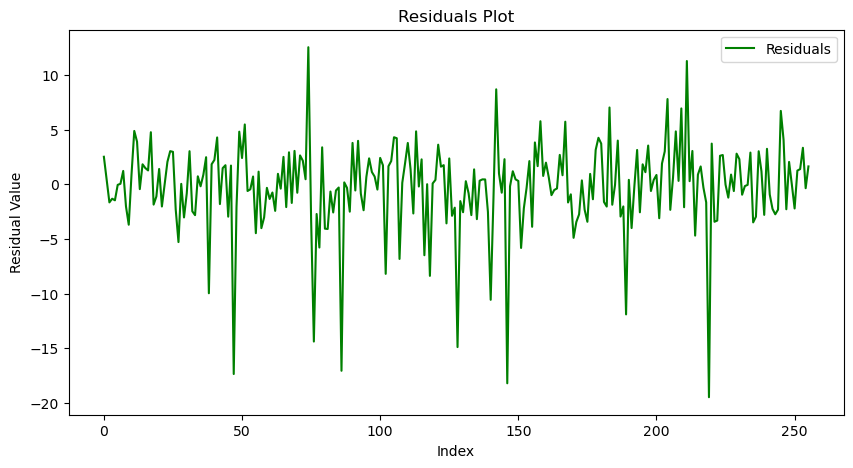

Index of the highest value in residuals: 74, Highest value: 12.552816390991211
Index of the lowest value in residuals: 219, Lowest value: -19.478925704956055
residuals excess kurtosis: 5.689615249633789


In [40]:
xb, yb = get_batch('train')
residuals = model.forward(xb, return_residuals=6)[30][0] # first batch, first word
# Plot the residuals
plt.figure(figsize=(10, 5))
plt.plot(residuals.cpu().detach().numpy(), label='Residuals', color='green')
plt.xlabel('Index')
plt.ylabel('Residual Value')
plt.title('Residuals Plot')
plt.legend()
plt.show()

# Get the index of the highest and lowest value in residuals
highest_value_index_residuals = torch.argmax(residuals).item()
lowest_value_index_residuals = torch.argmin(residuals).item()

# Get the highest and lowest value in residuals
highest_value_residuals = residuals[highest_value_index_residuals].item()
lowest_value_residuals = residuals[lowest_value_index_residuals].item()

print(f"Index of the highest value in residuals: {highest_value_index_residuals}, Highest value: {highest_value_residuals}")
print(f"Index of the lowest value in residuals: {lowest_value_index_residuals}, Lowest value: {lowest_value_residuals}")

print(f"residuals excess kurtosis: {excess_kurtosis(residuals)}")




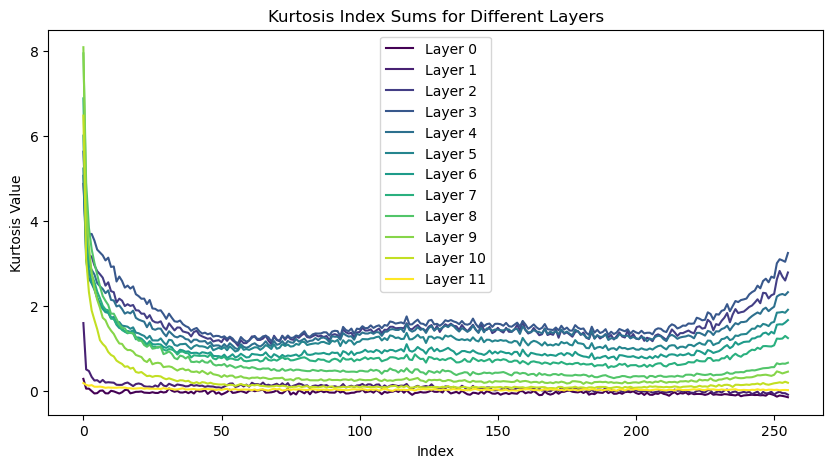

In [70]:
end_token_idx = C
embedding_layer = 6
num_batches_sampled = 20


@torch.no_grad
def get_kurtosis_idx_sums(embedding_layer, num_batches_sampled):
    kurtosis_idx_sums = torch.zeros(end_token_idx)
    for _ in range(num_batches_sampled):
        xb, yb = get_batch('train')
        residuals = model.forward(xb, return_residuals=embedding_layer)
        residuals_kurtosis_channel_mean = torch.mean(excess_kurtosis(residuals), dim=0)
        kurtosis_idx_sums += residuals_kurtosis_channel_mean
    return kurtosis_idx_sums / num_batches_sampled

kurtosis_idx_sums = []
for embedding_layer in range(12):
    kurtosis_idx_sums.append(get_kurtosis_idx_sums(embedding_layer, num_batches_sampled))
    # print(f"kurtosis idx sums for layer {embedding_layer}: {kurtosis_idx_sums}")


# Plot every kurtosis idx sums on the same plot
plt.figure(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(kurtosis_idx_sums)))
for i, kurtosis in enumerate(kurtosis_idx_sums):
    plt.plot(kurtosis.cpu().detach().numpy(), label=f'Layer {i}', color=colors[i])
plt.xlabel('Index')
plt.ylabel('Kurtosis Value')
plt.title('Kurtosis Index Sums for Different Layers')
plt.legend()
plt.show()






In [77]:
import torch

def kurtosis_stats_per_token(T, K, vocab_size):
    tokens = T.view(-1)
    kurtosis = K.view(-1)
    counts = torch.bincount(tokens, minlength=vocab_size)
    kurtosis_token_sums = torch.bincount(tokens, kurtosis, minlength=vocab_size)
    return kurtosis_token_sums, counts


input_tokens = torch.tensor([0,0,1,1,2])
input_kurtosis = torch.tensor([2,2,3,3,4])

print(kurtosis_stats_per_token(input_tokens, input_kurtosis, 4))



(tensor([4., 6., 4., 0.], device='cuda:0', dtype=torch.float64), tensor([2, 2, 1, 0], device='cuda:0'))


In [83]:
end_token_idx = C
embedding_layer = 6
num_batches_sampled = 1


@torch.no_grad
def get_kurtosis_idx_sums(embedding_layer, num_batches_sampled):
    kurtosis_idx_sums = torch.zeros(end_token_idx)
    for _ in range(num_batches_sampled):
        xb, yb = get_batch('train')
        residuals = model.forward(xb, return_residuals=embedding_layer)
        residuals_kurtosis_channel_mean = torch.mean(excess_kurtosis(residuals), dim=0)
        kurtosis_idx_sums += residuals_kurtosis_channel_mean
    return kurtosis_idx_sums / num_batches_sampled



@torch.no_grad
def get_kurtosis_avg(embedding_layer, num_batches_sampled, vocab_size):
    kurtosis_sums_accumulator = torch.zeros(vocab_size)
    counts_accumulator = torch.zeros(vocab_size)
    for i in range(num_batches_sampled):
        xb, yb = get_batch('train')
        residuals = model.forward(xb, return_residuals=embedding_layer)
        kurtosis_per_token = excess_kurtosis(residuals)
        kurtosis_token_sums, counts = kurtosis_stats_per_token(xb, kurtosis_per_token, vocab_size)
        kurtosis_sums_accumulator += kurtosis_token_sums
        counts_accumulator += counts
    kurtosis_avg = kurtosis_sums_accumulator / torch.max(counts_accumulator, torch.tensor(1.0))
    return kurtosis_avg, counts

kurtosis_avg, counts = get_kurtosis_avg(6, 100, tokenizer_vocab_size)

















In [85]:

condition = counts > 10 

smushed_kurtosis_avg = torch.where(condition, kurtosis_avg, torch.zeros_like(kurtosis_avg))
expanded_kurtosis_avg = torch.where(condition, kurtosis_avg, torch.full_like(kurtosis_avg, float('inf')))

top_k_kurtosis_indices = torch.topk(smushed_kurtosis_avg, 100).indices
bottom_k_kurtosis_indices = torch.topk(expanded_kurtosis_avg, 100, largest=False).indices


for idx in top_k_kurtosis_indices[:1000]:
    print(f"token: {tokenizer.decode([idx]):<20} count: {counts[idx]:<10} kurtosis: {kurtosis_avg[idx].item():.2f}")



token: That                 count: 12         kurtosis: 2.72
token: I                    count: 27         kurtosis: 2.58
token:  little              count: 48         kurtosis: 1.99
token:  
                   count: 53         kurtosis: 1.81
token: Once                 count: 43         kurtosis: 1.78
token:  decided             count: 11         kurtosis: 1.72
token:  rhinoceros          count: 12         kurtosis: 1.71
token:  rabbit              count: 17         kurtosis: 1.71
token:  The                 count: 71         kurtosis: 1.69
token:  thanked             count: 11         kurtosis: 1.69
token:  But                 count: 31         kurtosis: 1.67
token:  One                 count: 30         kurtosis: 1.67
token: One                  count: 22         kurtosis: 1.67
token:  He                  count: 167        kurtosis: 1.66
token:  thought             count: 24         kurtosis: 1.65
token:  knew                count: 21         kurtosis: 1.62
token:  saw             

In [63]:
# get the scaling factor such that the activations of the dataset have an l2 norm
# of sqrt(C)

# get the average l2 norm of the dataset, sampling from it

num_l2_samples = 50

sample_l2_norms = []
for i in range(num_l2_samples):
    xb, yb = get_batch('train')
    residuals = model(xb, return_residuals=True)
    l2_norm = torch.norm(residuals, dim=-1)
    avg_l2_norm = torch.mean(l2_norm).item()
    sample_l2_norms.append(avg_l2_norm)


l2_avg = sum(sample_l2_norms) / num_l2_samples
scaling_factor = (C)**.5 / l2_avg
print(f"scaling factor: {scaling_factor}")
print(f"l2 avg: {l2_avg}")

print(f"l2 avg * scaling factor: {l2_avg * scaling_factor}")


scaling factor: 0.7111385005244215
l2 avg: 22.49913341522217
l2 avg * scaling factor: 16.0


# Sparse AutoEncoder

In [59]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, activations_dim, sparse_dim):
        super().__init__()
        self.activations_dim = activations_dim
        encoder_weight = torch.randn(activations_dim, sparse_dim)
        decoder_weight = torch.randn(sparse_dim, activations_dim)
        self.encoder_bias = nn.Parameter(torch.zeros(sparse_dim))
        self.decoder_bias = nn.Parameter(torch.zeros(activations_dim))
        self.sparse_dim = sparse_dim
        self.sparsity_penalty = 30

        # set the encoder_weight to have the activations dim to be normalized to have l2 norm randomly between 0.05 and 1
        direction_lengths = torch.rand(sparse_dim) * 0.95 + 0.05
        # normalize the encoder_weight along columns (dim -2) to have l2 norm of 1
        encoder_weight = F.normalize(encoder_weight, p=2, dim=0)
        # multiply the column norms by the direction_lengths
        encoder_weight = encoder_weight * direction_lengths
        # make the decoder weight be the transpose of the encoder_weight
        decoder_weight = torch.transpose(encoder_weight, 0, 1)

        self.encoder_weight = nn.Parameter(encoder_weight)
        self.decoder_weight = nn.Parameter(decoder_weight)



    def forward(self, x):
        # preprocessing normalization
        # average_l2 norm of channel dimension:
        x = x * scaling_factor
        # now on average any embedding has euclidian length 1

        encoded = F.relu(x @ self.encoder_weight + self.encoder_bias) # all act. are positive
        decoded = encoded @ self.decoder_weight + self.decoder_bias

        reconstruction_l2_loss = F.mse_loss(x, decoded)

        # every row in the tall decoder matrix
        # is the "sum" of the total influence of a feature on the output
        # the l2 norm of that row is the "influence" of that feature on that output
        # calculate that, store as row
        decoder_l2 = torch.linalg.norm(self.decoder_weight, dim=-1)
        # the feature activation is the sparse activation * it's influence on output
        feature_activations = (encoded) * decoder_l2
        # sum of feature activations
        # divide by the batch size * sequence length
        # should work if there is no batch dimension
        if x.ndim == 3:
            batch_dim, sequence_dim, _ = x.shape
        elif x.ndim == 2:
            batch_dim = 1
            sequence_dim, _ = x.shape
        elif x.ndim == 1:
            batch_dim = 1
            sequence_dim = 1
        else:
            raise ValueError(f"x has {x.ndim} dimensions, but it should have 1, 2, or 3")
        
        sparsity_loss = torch.sum(feature_activations) * self.sparsity_penalty / (batch_dim * sequence_dim * self.sparse_dim)

        total_loss = reconstruction_l2_loss + sparsity_loss

        return {"encoded": encoded, "decoded": decoded, 'feature_activations': feature_activations, "reconstruction_loss": reconstruction_l2_loss, "sparsity_loss": sparsity_loss, "total_loss": total_loss}




# def test_sparse_autoencoder_sequence_independence():
#     sae = SparseAutoEncoder(100, 300)
#     input_embedding = torch.randn(2, 100)

#     input_embedding_modified = input_embedding.clone()
#     # modify the first in the sequence to be zeros
#     input_embedding_modified[0, :] = torch.zeros(100)
#     original_output = sae.forward(input_embedding)['decoded']
#     modified_output = sae.forward(input_embedding_modified)['decoded']

#     # make sure the last embedding in the sequence is the same, and the first is different
#     assert torch.all(original_output[-1, :] == modified_output[-1, :])
#     assert not torch.all(original_output[0, :] == modified_output[0, :])

# test_sparse_autoencoder_sequence_independence()

# def count_num_params_in_sae(sparse_dim_size):
#     sae = SparseAutoEncoder(C, sparse_dim_size)
#     num_params = sum(p.numel() for p in sae.parameters())
#     return num_params

# print("number of parameters:", count_num_params_in_sae(2**14))
# print(2**14)

# def reconstruction_training_run(embedding_size, sparse_dim_size, iters, eval_frequency):
#     def generate_tensor():
#         return torch.randn(embedding_size)
    
#     sae = SparseAutoEncoder(embedding_size, sparse_dim_size)
    
#     optimizer = torch.optim.Adam(sae.parameters(), lr=0.0005)
    
#     for i in range(iters):
#         optimizer.zero_grad()
#         input_tensor = generate_tensor()
#         output = sae.forward(input_tensor)
#         loss = output['total_loss']
#         loss.backward()
        
#         # Clip the gradient norm to 1
#         torch.nn.utils.clip_grad_norm_(sae.parameters(), max_norm=1)
        
#         optimizer.step()
        
#         if i % eval_frequency == 0:
#             avg_loss = 0
#             num_samples = 100  # Number of samples to average over
#             for _ in range(num_samples):
#                 input_tensor = generate_tensor()
#                 output = sae.forward(input_tensor)
#                 avg_loss += output['total_loss'].item()
#             avg_loss /= num_samples
#             print(f"Iteration {i}, Average Total Loss: {avg_loss}")
#     return sae

# reconstruction_training_run(C, 2**14, 10_000, 500)





In [50]:
len(train_data)

421949048

In [51]:
list(range(0, 10, 3))

[0, 3, 6, 9]

# Saving Embeddings

In [50]:
acumulated_residuals = []
del acumulated_residuals
torch.cuda.empty_cache()


In [42]:


def get_context_window(split, ix):
    data = train_data if split == 'train' else val_data
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y


accumulated_residuals = []
residuals_per_save = 10_000
save_idx = 0

with torch.no_grad():
    for split in ['train', 'val']:
        data = train_data if split == 'train' else val_data
        tokens_in_batch = B*T
        for i in tqdm(range(0, len(data)-tokens_in_batch, tokens_in_batch)): # the - tokens_in_batch is there so we skip the last, potentially unfull batch
            # B ixs, step is T, start at i
            ixs = torch.arange(i, i+tokens_in_batch, T)
            xb, yb = get_context_window(split, ixs)
            residuals = model(xb, return_residuals=model_embedding_layer)
        
            accumulated_residuals.append(residuals)
            if len(accumulated_residuals) >= residuals_per_save:
                torch.save(accumulated_residuals, f"residuals/residuals_{split}_{save_idx}.pt")
                accumulated_residuals = []
                save_idx += 1
        torch.save(accumulated_residuals, f"residuals/residuals_{split}_{save_idx}.pt")




        


  1%|▏         | 323/25753 [00:05<07:18, 57.99it/s]


KeyboardInterrupt: 

## SAE Training

In [60]:
sae = SparseAutoEncoder(C, 2**14)

In [90]:
2**14

16384

In [41]:
# forward the sae on random data
random_input = torch.randn(64, 200, C)
print(random_input.shape)
sae.forward(random_input)

torch.Size([64, 200, 256])


{'encoded': tensor([[[0.0000e+00, 1.0928e-01, 5.5051e-01,  ..., 1.3937e-02,
           4.8381e-02, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 2.3867e-01,  ..., 0.0000e+00,
           8.2960e-03, 0.0000e+00],
          [3.0629e-01, 0.0000e+00, 5.8424e-01,  ..., 3.0462e-02,
           0.0000e+00, 2.3872e-01],
          ...,
          [0.0000e+00, 0.0000e+00, 6.7199e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.3571e-01, 0.0000e+00, 1.2067e+00,  ..., 3.0096e-01,
           1.8543e-01, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 3.5603e-01,  ..., 0.0000e+00,
           1.5613e-01, 4.0485e-01]],
 
         [[1.8791e-01, 8.4111e-01, 7.4034e-01,  ..., 0.0000e+00,
           0.0000e+00, 1.2236e-01],
          [0.0000e+00, 0.0000e+00, 9.4327e-01,  ..., 3.6660e-01,
           7.2393e-02, 2.8086e-01],
          [0.0000e+00, 0.0000e+00, 4.5286e-01,  ..., 2.4790e-02,
           2.3059e-01, 0.0000e+00],
          ...,
          [5.5343e-01, 5.9949e-01, 3.1343e-01, 

In [ ]:
# import gc
# del sae
# del random_input
# gc.collect()
# torch.cuda.empty_cache()

In [42]:
# Freeze all params in GPT model
for param in model.parameters():
    param.requires_grad = False


sae_eval_iters = 10
sae_eval_interval = 300


@torch.no_grad()
def estimate_sae_loss(is_last=False):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        real_iters = sae_eval_iters
        if is_last and split == 'val':
            real_iters *= 10
        losses = torch.zeros(real_iters)
        sparsity_losses = torch.zeros(real_iters)
        reconstruction_losses = torch.zeros(real_iters)
        for k in range(real_iters):
            X, Y = get_batch(split)
            residuals = model(X, return_residuals=model_embedding_layer)
            sae_output = sae(residuals)
            sae_reconstruction_loss = sae_output['reconstruction_loss']
            sae_sparsity_loss = sae_output['sparsity_loss']
            sae_total_loss = sae_output['total_loss']
            losses[k] = sae_total_loss
            sparsity_losses[k] = sae_sparsity_loss
            reconstruction_losses[k] = sae_reconstruction_loss
        out[split] = {"losses": losses.mean(), "sparsity_losses": sparsity_losses.mean(), "reconstruction_losses": reconstruction_losses.mean()}
    return out

estimate_sae_loss()

{'train': {'losses': tensor(383.5997, device='cuda:0'),
  'sparsity_losses': tensor(7.6470, device='cuda:0'),
  'reconstruction_losses': tensor(375.9527, device='cuda:0')},
 'val': {'losses': tensor(383.7079, device='cuda:0'),
  'sparsity_losses': tensor(7.6472, device='cuda:0'),
  'reconstruction_losses': tensor(376.0606, device='cuda:0')}}

In [48]:
optimizer = torch.optim.Adam(sae.parameters(), lr=sae_learning_rate)
eval_interval=500
max_iters = 150000

import tqdm


for steps in tqdm.tqdm(range(max_iters)):
    xb, yb = get_batch('train')
    residuals = model(xb, return_residuals=model_embedding_layer)
    optimizer.zero_grad(set_to_none=True)
    sae_output = sae(residuals)
    sae_reconstruction_loss = sae_output['reconstruction_loss']
    sae_sparsity_loss = sae_output['sparsity_loss']
    ratio_done_training = steps/max_iters

    
    loss = sae_reconstruction_loss + sae_sparsity_loss

    loss.backward()
    torch.nn.utils.clip_grad_norm_(sae.parameters(), max_norm=1)


    optimizer.step()

    if steps % eval_interval == 0:
        loss_data = estimate_sae_loss()
        train_loss_data = loss_data['train']
        val_loss_data = loss_data['val']
        print("train loss info")
        print(train_loss_data)
        print("val loss info")
        print(val_loss_data)
        # print(f"sparsity_loss_weight: {sparsity_loss_weight}")
        print("------")

estimate_loss(is_last=True)

  0%|          | 3/150000 [00:00<10:30:44,  3.96it/s]

train loss info
{'losses': tensor(0.4253, device='cuda:0'), 'sparsity_losses': tensor(0.2437, device='cuda:0'), 'reconstruction_losses': tensor(0.1816, device='cuda:0')}
val loss info
{'losses': tensor(0.4252, device='cuda:0'), 'sparsity_losses': tensor(0.2440, device='cuda:0'), 'reconstruction_losses': tensor(0.1812, device='cuda:0')}
------


  0%|          | 503/150000 [00:32<5:25:11,  7.66it/s]

train loss info
{'losses': tensor(0.4001, device='cuda:0'), 'sparsity_losses': tensor(0.2386, device='cuda:0'), 'reconstruction_losses': tensor(0.1615, device='cuda:0')}
val loss info
{'losses': tensor(0.4007, device='cuda:0'), 'sparsity_losses': tensor(0.2387, device='cuda:0'), 'reconstruction_losses': tensor(0.1620, device='cuda:0')}
------


  1%|          | 1003/150000 [01:03<5:21:12,  7.73it/s]

train loss info
{'losses': tensor(0.3939, device='cuda:0'), 'sparsity_losses': tensor(0.2386, device='cuda:0'), 'reconstruction_losses': tensor(0.1553, device='cuda:0')}
val loss info
{'losses': tensor(0.3942, device='cuda:0'), 'sparsity_losses': tensor(0.2400, device='cuda:0'), 'reconstruction_losses': tensor(0.1543, device='cuda:0')}
------


  1%|          | 1503/150000 [01:34<5:27:56,  7.55it/s]

train loss info
{'losses': tensor(0.3837, device='cuda:0'), 'sparsity_losses': tensor(0.2367, device='cuda:0'), 'reconstruction_losses': tensor(0.1470, device='cuda:0')}
val loss info
{'losses': tensor(0.3839, device='cuda:0'), 'sparsity_losses': tensor(0.2361, device='cuda:0'), 'reconstruction_losses': tensor(0.1478, device='cuda:0')}
------


  1%|▏         | 2003/150000 [02:04<5:18:38,  7.74it/s]

train loss info
{'losses': tensor(0.3766, device='cuda:0'), 'sparsity_losses': tensor(0.2343, device='cuda:0'), 'reconstruction_losses': tensor(0.1423, device='cuda:0')}
val loss info
{'losses': tensor(0.3770, device='cuda:0'), 'sparsity_losses': tensor(0.2340, device='cuda:0'), 'reconstruction_losses': tensor(0.1429, device='cuda:0')}
------


  2%|▏         | 2503/150000 [02:35<5:18:28,  7.72it/s]

train loss info
{'losses': tensor(0.3722, device='cuda:0'), 'sparsity_losses': tensor(0.2331, device='cuda:0'), 'reconstruction_losses': tensor(0.1391, device='cuda:0')}
val loss info
{'losses': tensor(0.3720, device='cuda:0'), 'sparsity_losses': tensor(0.2328, device='cuda:0'), 'reconstruction_losses': tensor(0.1392, device='cuda:0')}
------


  2%|▏         | 3003/150000 [03:07<5:37:33,  7.26it/s]

train loss info
{'losses': tensor(0.3669, device='cuda:0'), 'sparsity_losses': tensor(0.2318, device='cuda:0'), 'reconstruction_losses': tensor(0.1351, device='cuda:0')}
val loss info
{'losses': tensor(0.3669, device='cuda:0'), 'sparsity_losses': tensor(0.2313, device='cuda:0'), 'reconstruction_losses': tensor(0.1357, device='cuda:0')}
------


  2%|▏         | 3503/150000 [03:38<5:38:05,  7.22it/s]

train loss info
{'losses': tensor(0.3631, device='cuda:0'), 'sparsity_losses': tensor(0.2286, device='cuda:0'), 'reconstruction_losses': tensor(0.1345, device='cuda:0')}
val loss info
{'losses': tensor(0.3632, device='cuda:0'), 'sparsity_losses': tensor(0.2291, device='cuda:0'), 'reconstruction_losses': tensor(0.1341, device='cuda:0')}
------


  3%|▎         | 4003/150000 [04:09<5:17:42,  7.66it/s]

train loss info
{'losses': tensor(0.3621, device='cuda:0'), 'sparsity_losses': tensor(0.2299, device='cuda:0'), 'reconstruction_losses': tensor(0.1322, device='cuda:0')}
val loss info
{'losses': tensor(0.3616, device='cuda:0'), 'sparsity_losses': tensor(0.2297, device='cuda:0'), 'reconstruction_losses': tensor(0.1319, device='cuda:0')}
------


  3%|▎         | 4503/150000 [04:40<5:17:41,  7.63it/s]

train loss info
{'losses': tensor(0.3605, device='cuda:0'), 'sparsity_losses': tensor(0.2302, device='cuda:0'), 'reconstruction_losses': tensor(0.1303, device='cuda:0')}
val loss info
{'losses': tensor(0.3603, device='cuda:0'), 'sparsity_losses': tensor(0.2302, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
------


  3%|▎         | 5003/150000 [05:11<5:12:09,  7.74it/s]

train loss info
{'losses': tensor(0.3587, device='cuda:0'), 'sparsity_losses': tensor(0.2284, device='cuda:0'), 'reconstruction_losses': tensor(0.1303, device='cuda:0')}
val loss info
{'losses': tensor(0.3585, device='cuda:0'), 'sparsity_losses': tensor(0.2282, device='cuda:0'), 'reconstruction_losses': tensor(0.1304, device='cuda:0')}
------


  4%|▎         | 5503/150000 [05:39<4:55:13,  8.16it/s]

train loss info
{'losses': tensor(0.3586, device='cuda:0'), 'sparsity_losses': tensor(0.2288, device='cuda:0'), 'reconstruction_losses': tensor(0.1298, device='cuda:0')}
val loss info
{'losses': tensor(0.3580, device='cuda:0'), 'sparsity_losses': tensor(0.2283, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
------


  4%|▍         | 6003/150000 [06:07<4:55:56,  8.11it/s]

train loss info
{'losses': tensor(0.3588, device='cuda:0'), 'sparsity_losses': tensor(0.2288, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
val loss info
{'losses': tensor(0.3587, device='cuda:0'), 'sparsity_losses': tensor(0.2283, device='cuda:0'), 'reconstruction_losses': tensor(0.1304, device='cuda:0')}
------


  4%|▍         | 6503/150000 [06:36<4:43:59,  8.42it/s]

train loss info
{'losses': tensor(0.3586, device='cuda:0'), 'sparsity_losses': tensor(0.2282, device='cuda:0'), 'reconstruction_losses': tensor(0.1305, device='cuda:0')}
val loss info
{'losses': tensor(0.3597, device='cuda:0'), 'sparsity_losses': tensor(0.2283, device='cuda:0'), 'reconstruction_losses': tensor(0.1314, device='cuda:0')}
------


  5%|▍         | 7003/150000 [07:04<4:42:33,  8.43it/s]

train loss info
{'losses': tensor(0.3598, device='cuda:0'), 'sparsity_losses': tensor(0.2291, device='cuda:0'), 'reconstruction_losses': tensor(0.1307, device='cuda:0')}
val loss info
{'losses': tensor(0.3602, device='cuda:0'), 'sparsity_losses': tensor(0.2288, device='cuda:0'), 'reconstruction_losses': tensor(0.1314, device='cuda:0')}
------


  5%|▌         | 7503/150000 [07:33<4:41:30,  8.44it/s]

train loss info
{'losses': tensor(0.3605, device='cuda:0'), 'sparsity_losses': tensor(0.2287, device='cuda:0'), 'reconstruction_losses': tensor(0.1319, device='cuda:0')}
val loss info
{'losses': tensor(0.3603, device='cuda:0'), 'sparsity_losses': tensor(0.2281, device='cuda:0'), 'reconstruction_losses': tensor(0.1322, device='cuda:0')}
------


  5%|▌         | 8003/150000 [08:01<4:55:17,  8.01it/s]

train loss info
{'losses': tensor(0.3607, device='cuda:0'), 'sparsity_losses': tensor(0.2278, device='cuda:0'), 'reconstruction_losses': tensor(0.1329, device='cuda:0')}
val loss info
{'losses': tensor(0.3600, device='cuda:0'), 'sparsity_losses': tensor(0.2273, device='cuda:0'), 'reconstruction_losses': tensor(0.1327, device='cuda:0')}
------


  6%|▌         | 8503/150000 [08:29<4:47:58,  8.19it/s]

train loss info
{'losses': tensor(0.3620, device='cuda:0'), 'sparsity_losses': tensor(0.2281, device='cuda:0'), 'reconstruction_losses': tensor(0.1338, device='cuda:0')}
val loss info
{'losses': tensor(0.3622, device='cuda:0'), 'sparsity_losses': tensor(0.2289, device='cuda:0'), 'reconstruction_losses': tensor(0.1332, device='cuda:0')}
------


  6%|▌         | 9003/150000 [08:57<4:38:52,  8.43it/s]

train loss info
{'losses': tensor(0.3625, device='cuda:0'), 'sparsity_losses': tensor(0.2281, device='cuda:0'), 'reconstruction_losses': tensor(0.1344, device='cuda:0')}
val loss info
{'losses': tensor(0.3627, device='cuda:0'), 'sparsity_losses': tensor(0.2286, device='cuda:0'), 'reconstruction_losses': tensor(0.1342, device='cuda:0')}
------


  6%|▋         | 9503/150000 [09:25<4:58:26,  7.85it/s]

train loss info
{'losses': tensor(0.3627, device='cuda:0'), 'sparsity_losses': tensor(0.2274, device='cuda:0'), 'reconstruction_losses': tensor(0.1353, device='cuda:0')}
val loss info
{'losses': tensor(0.3636, device='cuda:0'), 'sparsity_losses': tensor(0.2280, device='cuda:0'), 'reconstruction_losses': tensor(0.1356, device='cuda:0')}
------


  7%|▋         | 10003/150000 [09:54<4:47:55,  8.10it/s]

train loss info
{'losses': tensor(0.3642, device='cuda:0'), 'sparsity_losses': tensor(0.2271, device='cuda:0'), 'reconstruction_losses': tensor(0.1371, device='cuda:0')}
val loss info
{'losses': tensor(0.3639, device='cuda:0'), 'sparsity_losses': tensor(0.2273, device='cuda:0'), 'reconstruction_losses': tensor(0.1366, device='cuda:0')}
------


  7%|▋         | 10503/150000 [10:22<4:37:59,  8.36it/s]

train loss info
{'losses': tensor(0.3639, device='cuda:0'), 'sparsity_losses': tensor(0.2261, device='cuda:0'), 'reconstruction_losses': tensor(0.1379, device='cuda:0')}
val loss info
{'losses': tensor(0.3650, device='cuda:0'), 'sparsity_losses': tensor(0.2265, device='cuda:0'), 'reconstruction_losses': tensor(0.1385, device='cuda:0')}
------


  7%|▋         | 11003/150000 [10:51<4:35:30,  8.41it/s]

train loss info
{'losses': tensor(0.3645, device='cuda:0'), 'sparsity_losses': tensor(0.2265, device='cuda:0'), 'reconstruction_losses': tensor(0.1380, device='cuda:0')}
val loss info
{'losses': tensor(0.3642, device='cuda:0'), 'sparsity_losses': tensor(0.2262, device='cuda:0'), 'reconstruction_losses': tensor(0.1380, device='cuda:0')}
------


  8%|▊         | 11503/150000 [11:20<4:46:16,  8.06it/s]

train loss info
{'losses': tensor(0.3654, device='cuda:0'), 'sparsity_losses': tensor(0.2264, device='cuda:0'), 'reconstruction_losses': tensor(0.1391, device='cuda:0')}
val loss info
{'losses': tensor(0.3647, device='cuda:0'), 'sparsity_losses': tensor(0.2254, device='cuda:0'), 'reconstruction_losses': tensor(0.1393, device='cuda:0')}
------


  8%|▊         | 12003/150000 [11:48<4:41:16,  8.18it/s]

train loss info
{'losses': tensor(0.3647, device='cuda:0'), 'sparsity_losses': tensor(0.2252, device='cuda:0'), 'reconstruction_losses': tensor(0.1395, device='cuda:0')}
val loss info
{'losses': tensor(0.3642, device='cuda:0'), 'sparsity_losses': tensor(0.2251, device='cuda:0'), 'reconstruction_losses': tensor(0.1391, device='cuda:0')}
------


  8%|▊         | 12503/150000 [12:17<4:51:34,  7.86it/s]

train loss info
{'losses': tensor(0.3654, device='cuda:0'), 'sparsity_losses': tensor(0.2248, device='cuda:0'), 'reconstruction_losses': tensor(0.1406, device='cuda:0')}
val loss info
{'losses': tensor(0.3647, device='cuda:0'), 'sparsity_losses': tensor(0.2250, device='cuda:0'), 'reconstruction_losses': tensor(0.1396, device='cuda:0')}
------


  9%|▊         | 13003/150000 [12:45<4:30:21,  8.45it/s]

train loss info
{'losses': tensor(0.3658, device='cuda:0'), 'sparsity_losses': tensor(0.2249, device='cuda:0'), 'reconstruction_losses': tensor(0.1409, device='cuda:0')}
val loss info
{'losses': tensor(0.3653, device='cuda:0'), 'sparsity_losses': tensor(0.2250, device='cuda:0'), 'reconstruction_losses': tensor(0.1402, device='cuda:0')}
------


  9%|▉         | 13503/150000 [13:13<4:30:35,  8.41it/s]

train loss info
{'losses': tensor(0.3672, device='cuda:0'), 'sparsity_losses': tensor(0.2250, device='cuda:0'), 'reconstruction_losses': tensor(0.1421, device='cuda:0')}
val loss info
{'losses': tensor(0.3659, device='cuda:0'), 'sparsity_losses': tensor(0.2251, device='cuda:0'), 'reconstruction_losses': tensor(0.1407, device='cuda:0')}
------


  9%|▉         | 14003/150000 [13:41<4:29:01,  8.43it/s]

train loss info
{'losses': tensor(0.3660, device='cuda:0'), 'sparsity_losses': tensor(0.2238, device='cuda:0'), 'reconstruction_losses': tensor(0.1422, device='cuda:0')}
val loss info
{'losses': tensor(0.3658, device='cuda:0'), 'sparsity_losses': tensor(0.2237, device='cuda:0'), 'reconstruction_losses': tensor(0.1421, device='cuda:0')}
------


 10%|▉         | 14503/150000 [14:09<4:27:09,  8.45it/s]

train loss info
{'losses': tensor(0.3647, device='cuda:0'), 'sparsity_losses': tensor(0.2225, device='cuda:0'), 'reconstruction_losses': tensor(0.1422, device='cuda:0')}
val loss info
{'losses': tensor(0.3646, device='cuda:0'), 'sparsity_losses': tensor(0.2221, device='cuda:0'), 'reconstruction_losses': tensor(0.1425, device='cuda:0')}
------


 10%|█         | 15003/150000 [14:37<4:28:41,  8.37it/s]

train loss info
{'losses': tensor(0.3658, device='cuda:0'), 'sparsity_losses': tensor(0.2223, device='cuda:0'), 'reconstruction_losses': tensor(0.1435, device='cuda:0')}
val loss info
{'losses': tensor(0.3654, device='cuda:0'), 'sparsity_losses': tensor(0.2228, device='cuda:0'), 'reconstruction_losses': tensor(0.1425, device='cuda:0')}
------


 10%|█         | 15503/150000 [15:06<4:25:39,  8.44it/s]

train loss info
{'losses': tensor(0.3651, device='cuda:0'), 'sparsity_losses': tensor(0.2221, device='cuda:0'), 'reconstruction_losses': tensor(0.1429, device='cuda:0')}
val loss info
{'losses': tensor(0.3646, device='cuda:0'), 'sparsity_losses': tensor(0.2221, device='cuda:0'), 'reconstruction_losses': tensor(0.1425, device='cuda:0')}
------


 11%|█         | 16003/150000 [15:34<4:39:59,  7.98it/s]

train loss info
{'losses': tensor(0.3637, device='cuda:0'), 'sparsity_losses': tensor(0.2204, device='cuda:0'), 'reconstruction_losses': tensor(0.1433, device='cuda:0')}
val loss info
{'losses': tensor(0.3636, device='cuda:0'), 'sparsity_losses': tensor(0.2205, device='cuda:0'), 'reconstruction_losses': tensor(0.1431, device='cuda:0')}
------


 11%|█         | 16503/150000 [16:02<4:23:29,  8.44it/s]

train loss info
{'losses': tensor(0.3632, device='cuda:0'), 'sparsity_losses': tensor(0.2205, device='cuda:0'), 'reconstruction_losses': tensor(0.1427, device='cuda:0')}
val loss info
{'losses': tensor(0.3631, device='cuda:0'), 'sparsity_losses': tensor(0.2206, device='cuda:0'), 'reconstruction_losses': tensor(0.1425, device='cuda:0')}
------


 11%|█▏        | 17003/150000 [16:29<4:22:51,  8.43it/s]

train loss info
{'losses': tensor(0.3626, device='cuda:0'), 'sparsity_losses': tensor(0.2192, device='cuda:0'), 'reconstruction_losses': tensor(0.1434, device='cuda:0')}
val loss info
{'losses': tensor(0.3625, device='cuda:0'), 'sparsity_losses': tensor(0.2192, device='cuda:0'), 'reconstruction_losses': tensor(0.1433, device='cuda:0')}
------


 12%|█▏        | 17503/150000 [16:58<4:55:51,  7.46it/s]

train loss info
{'losses': tensor(0.3616, device='cuda:0'), 'sparsity_losses': tensor(0.2182, device='cuda:0'), 'reconstruction_losses': tensor(0.1434, device='cuda:0')}
val loss info
{'losses': tensor(0.3620, device='cuda:0'), 'sparsity_losses': tensor(0.2180, device='cuda:0'), 'reconstruction_losses': tensor(0.1440, device='cuda:0')}
------


 12%|█▏        | 18003/150000 [17:26<4:20:44,  8.44it/s]

train loss info
{'losses': tensor(0.3596, device='cuda:0'), 'sparsity_losses': tensor(0.2169, device='cuda:0'), 'reconstruction_losses': tensor(0.1427, device='cuda:0')}
val loss info
{'losses': tensor(0.3597, device='cuda:0'), 'sparsity_losses': tensor(0.2166, device='cuda:0'), 'reconstruction_losses': tensor(0.1431, device='cuda:0')}
------


 12%|█▏        | 18503/150000 [17:54<4:23:34,  8.32it/s]

train loss info
{'losses': tensor(0.3591, device='cuda:0'), 'sparsity_losses': tensor(0.2165, device='cuda:0'), 'reconstruction_losses': tensor(0.1426, device='cuda:0')}
val loss info
{'losses': tensor(0.3583, device='cuda:0'), 'sparsity_losses': tensor(0.2163, device='cuda:0'), 'reconstruction_losses': tensor(0.1421, device='cuda:0')}
------


 13%|█▎        | 19003/150000 [18:22<4:41:04,  7.77it/s]

train loss info
{'losses': tensor(0.3578, device='cuda:0'), 'sparsity_losses': tensor(0.2155, device='cuda:0'), 'reconstruction_losses': tensor(0.1424, device='cuda:0')}
val loss info
{'losses': tensor(0.3585, device='cuda:0'), 'sparsity_losses': tensor(0.2156, device='cuda:0'), 'reconstruction_losses': tensor(0.1428, device='cuda:0')}
------


 13%|█▎        | 19503/150000 [18:50<4:17:52,  8.43it/s]

train loss info
{'losses': tensor(0.3569, device='cuda:0'), 'sparsity_losses': tensor(0.2151, device='cuda:0'), 'reconstruction_losses': tensor(0.1418, device='cuda:0')}
val loss info
{'losses': tensor(0.3575, device='cuda:0'), 'sparsity_losses': tensor(0.2150, device='cuda:0'), 'reconstruction_losses': tensor(0.1424, device='cuda:0')}
------


 13%|█▎        | 20003/150000 [19:19<4:38:24,  7.78it/s]

train loss info
{'losses': tensor(0.3561, device='cuda:0'), 'sparsity_losses': tensor(0.2148, device='cuda:0'), 'reconstruction_losses': tensor(0.1413, device='cuda:0')}
val loss info
{'losses': tensor(0.3554, device='cuda:0'), 'sparsity_losses': tensor(0.2145, device='cuda:0'), 'reconstruction_losses': tensor(0.1409, device='cuda:0')}
------


 14%|█▎        | 20503/150000 [19:48<4:26:11,  8.11it/s]

train loss info
{'losses': tensor(0.3542, device='cuda:0'), 'sparsity_losses': tensor(0.2136, device='cuda:0'), 'reconstruction_losses': tensor(0.1406, device='cuda:0')}
val loss info
{'losses': tensor(0.3552, device='cuda:0'), 'sparsity_losses': tensor(0.2138, device='cuda:0'), 'reconstruction_losses': tensor(0.1415, device='cuda:0')}
------


 14%|█▍        | 21003/150000 [20:16<4:14:46,  8.44it/s]

train loss info
{'losses': tensor(0.3526, device='cuda:0'), 'sparsity_losses': tensor(0.2132, device='cuda:0'), 'reconstruction_losses': tensor(0.1394, device='cuda:0')}
val loss info
{'losses': tensor(0.3540, device='cuda:0'), 'sparsity_losses': tensor(0.2134, device='cuda:0'), 'reconstruction_losses': tensor(0.1406, device='cuda:0')}
------


 14%|█▍        | 21503/150000 [20:44<4:15:32,  8.38it/s]

train loss info
{'losses': tensor(0.3512, device='cuda:0'), 'sparsity_losses': tensor(0.2118, device='cuda:0'), 'reconstruction_losses': tensor(0.1394, device='cuda:0')}
val loss info
{'losses': tensor(0.3510, device='cuda:0'), 'sparsity_losses': tensor(0.2119, device='cuda:0'), 'reconstruction_losses': tensor(0.1391, device='cuda:0')}
------


 15%|█▍        | 22003/150000 [21:12<4:13:18,  8.42it/s]

train loss info
{'losses': tensor(0.3484, device='cuda:0'), 'sparsity_losses': tensor(0.2108, device='cuda:0'), 'reconstruction_losses': tensor(0.1376, device='cuda:0')}
val loss info
{'losses': tensor(0.3491, device='cuda:0'), 'sparsity_losses': tensor(0.2110, device='cuda:0'), 'reconstruction_losses': tensor(0.1381, device='cuda:0')}
------


 15%|█▌        | 22503/150000 [21:40<4:15:07,  8.33it/s]

train loss info
{'losses': tensor(0.3473, device='cuda:0'), 'sparsity_losses': tensor(0.2097, device='cuda:0'), 'reconstruction_losses': tensor(0.1376, device='cuda:0')}
val loss info
{'losses': tensor(0.3477, device='cuda:0'), 'sparsity_losses': tensor(0.2102, device='cuda:0'), 'reconstruction_losses': tensor(0.1375, device='cuda:0')}
------


 15%|█▌        | 23003/150000 [22:08<4:11:16,  8.42it/s]

train loss info
{'losses': tensor(0.3455, device='cuda:0'), 'sparsity_losses': tensor(0.2093, device='cuda:0'), 'reconstruction_losses': tensor(0.1362, device='cuda:0')}
val loss info
{'losses': tensor(0.3460, device='cuda:0'), 'sparsity_losses': tensor(0.2086, device='cuda:0'), 'reconstruction_losses': tensor(0.1373, device='cuda:0')}
------


 16%|█▌        | 23503/150000 [22:37<4:09:50,  8.44it/s]

train loss info
{'losses': tensor(0.3439, device='cuda:0'), 'sparsity_losses': tensor(0.2080, device='cuda:0'), 'reconstruction_losses': tensor(0.1359, device='cuda:0')}
val loss info
{'losses': tensor(0.3437, device='cuda:0'), 'sparsity_losses': tensor(0.2083, device='cuda:0'), 'reconstruction_losses': tensor(0.1354, device='cuda:0')}
------


 16%|█▌        | 24003/150000 [23:05<4:08:56,  8.44it/s]

train loss info
{'losses': tensor(0.3415, device='cuda:0'), 'sparsity_losses': tensor(0.2075, device='cuda:0'), 'reconstruction_losses': tensor(0.1341, device='cuda:0')}
val loss info
{'losses': tensor(0.3433, device='cuda:0'), 'sparsity_losses': tensor(0.2079, device='cuda:0'), 'reconstruction_losses': tensor(0.1353, device='cuda:0')}
------


 16%|█▋        | 24503/150000 [23:33<4:08:21,  8.42it/s]

train loss info
{'losses': tensor(0.3406, device='cuda:0'), 'sparsity_losses': tensor(0.2068, device='cuda:0'), 'reconstruction_losses': tensor(0.1338, device='cuda:0')}
val loss info
{'losses': tensor(0.3410, device='cuda:0'), 'sparsity_losses': tensor(0.2061, device='cuda:0'), 'reconstruction_losses': tensor(0.1350, device='cuda:0')}
------


 17%|█▋        | 25003/150000 [24:02<4:16:27,  8.12it/s]

train loss info
{'losses': tensor(0.3390, device='cuda:0'), 'sparsity_losses': tensor(0.2050, device='cuda:0'), 'reconstruction_losses': tensor(0.1340, device='cuda:0')}
val loss info
{'losses': tensor(0.3397, device='cuda:0'), 'sparsity_losses': tensor(0.2057, device='cuda:0'), 'reconstruction_losses': tensor(0.1340, device='cuda:0')}
------


 17%|█▋        | 25503/150000 [24:30<4:14:15,  8.16it/s]

train loss info
{'losses': tensor(0.3386, device='cuda:0'), 'sparsity_losses': tensor(0.2049, device='cuda:0'), 'reconstruction_losses': tensor(0.1337, device='cuda:0')}
val loss info
{'losses': tensor(0.3390, device='cuda:0'), 'sparsity_losses': tensor(0.2052, device='cuda:0'), 'reconstruction_losses': tensor(0.1338, device='cuda:0')}
------


 17%|█▋        | 26003/150000 [24:58<4:17:10,  8.04it/s]

train loss info
{'losses': tensor(0.3379, device='cuda:0'), 'sparsity_losses': tensor(0.2058, device='cuda:0'), 'reconstruction_losses': tensor(0.1321, device='cuda:0')}
val loss info
{'losses': tensor(0.3379, device='cuda:0'), 'sparsity_losses': tensor(0.2052, device='cuda:0'), 'reconstruction_losses': tensor(0.1327, device='cuda:0')}
------


 18%|█▊        | 26503/150000 [25:26<4:06:14,  8.36it/s]

train loss info
{'losses': tensor(0.3368, device='cuda:0'), 'sparsity_losses': tensor(0.2050, device='cuda:0'), 'reconstruction_losses': tensor(0.1317, device='cuda:0')}
val loss info
{'losses': tensor(0.3352, device='cuda:0'), 'sparsity_losses': tensor(0.2035, device='cuda:0'), 'reconstruction_losses': tensor(0.1317, device='cuda:0')}
------


 18%|█▊        | 27003/150000 [25:55<4:17:35,  7.96it/s]

train loss info
{'losses': tensor(0.3341, device='cuda:0'), 'sparsity_losses': tensor(0.2036, device='cuda:0'), 'reconstruction_losses': tensor(0.1306, device='cuda:0')}
val loss info
{'losses': tensor(0.3354, device='cuda:0'), 'sparsity_losses': tensor(0.2039, device='cuda:0'), 'reconstruction_losses': tensor(0.1315, device='cuda:0')}
------


 18%|█▊        | 27503/150000 [26:23<4:28:31,  7.60it/s]

train loss info
{'losses': tensor(0.3336, device='cuda:0'), 'sparsity_losses': tensor(0.2029, device='cuda:0'), 'reconstruction_losses': tensor(0.1306, device='cuda:0')}
val loss info
{'losses': tensor(0.3333, device='cuda:0'), 'sparsity_losses': tensor(0.2025, device='cuda:0'), 'reconstruction_losses': tensor(0.1308, device='cuda:0')}
------


 19%|█▊        | 28003/150000 [26:51<4:01:01,  8.44it/s]

train loss info
{'losses': tensor(0.3328, device='cuda:0'), 'sparsity_losses': tensor(0.2031, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
val loss info
{'losses': tensor(0.3328, device='cuda:0'), 'sparsity_losses': tensor(0.2028, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
------


 19%|█▉        | 28503/150000 [27:19<4:00:21,  8.42it/s]

train loss info
{'losses': tensor(0.3316, device='cuda:0'), 'sparsity_losses': tensor(0.2022, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
val loss info
{'losses': tensor(0.3317, device='cuda:0'), 'sparsity_losses': tensor(0.2024, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 19%|█▉        | 29003/150000 [27:46<3:59:12,  8.43it/s]

train loss info
{'losses': tensor(0.3306, device='cuda:0'), 'sparsity_losses': tensor(0.2021, device='cuda:0'), 'reconstruction_losses': tensor(0.1285, device='cuda:0')}
val loss info
{'losses': tensor(0.3306, device='cuda:0'), 'sparsity_losses': tensor(0.2021, device='cuda:0'), 'reconstruction_losses': tensor(0.1286, device='cuda:0')}
------


 20%|█▉        | 29503/150000 [28:14<3:58:15,  8.43it/s]

train loss info
{'losses': tensor(0.3295, device='cuda:0'), 'sparsity_losses': tensor(0.2013, device='cuda:0'), 'reconstruction_losses': tensor(0.1282, device='cuda:0')}
val loss info
{'losses': tensor(0.3304, device='cuda:0'), 'sparsity_losses': tensor(0.2019, device='cuda:0'), 'reconstruction_losses': tensor(0.1284, device='cuda:0')}
------


 20%|██        | 30003/150000 [28:42<3:57:27,  8.42it/s]

train loss info
{'losses': tensor(0.3293, device='cuda:0'), 'sparsity_losses': tensor(0.2008, device='cuda:0'), 'reconstruction_losses': tensor(0.1285, device='cuda:0')}
val loss info
{'losses': tensor(0.3278, device='cuda:0'), 'sparsity_losses': tensor(0.2003, device='cuda:0'), 'reconstruction_losses': tensor(0.1275, device='cuda:0')}
------


 20%|██        | 30503/150000 [29:10<3:57:14,  8.40it/s]

train loss info
{'losses': tensor(0.3278, device='cuda:0'), 'sparsity_losses': tensor(0.2004, device='cuda:0'), 'reconstruction_losses': tensor(0.1274, device='cuda:0')}
val loss info
{'losses': tensor(0.3286, device='cuda:0'), 'sparsity_losses': tensor(0.2004, device='cuda:0'), 'reconstruction_losses': tensor(0.1282, device='cuda:0')}
------


 21%|██        | 31003/150000 [29:38<3:58:57,  8.30it/s]

train loss info
{'losses': tensor(0.3270, device='cuda:0'), 'sparsity_losses': tensor(0.1998, device='cuda:0'), 'reconstruction_losses': tensor(0.1272, device='cuda:0')}
val loss info
{'losses': tensor(0.3276, device='cuda:0'), 'sparsity_losses': tensor(0.2000, device='cuda:0'), 'reconstruction_losses': tensor(0.1275, device='cuda:0')}
------


 21%|██        | 31503/150000 [30:07<3:54:23,  8.43it/s]

train loss info
{'losses': tensor(0.3260, device='cuda:0'), 'sparsity_losses': tensor(0.1993, device='cuda:0'), 'reconstruction_losses': tensor(0.1267, device='cuda:0')}
val loss info
{'losses': tensor(0.3264, device='cuda:0'), 'sparsity_losses': tensor(0.1993, device='cuda:0'), 'reconstruction_losses': tensor(0.1271, device='cuda:0')}
------


 21%|██▏       | 32003/150000 [30:35<3:53:34,  8.42it/s]

train loss info
{'losses': tensor(0.3260, device='cuda:0'), 'sparsity_losses': tensor(0.1996, device='cuda:0'), 'reconstruction_losses': tensor(0.1264, device='cuda:0')}
val loss info
{'losses': tensor(0.3267, device='cuda:0'), 'sparsity_losses': tensor(0.1995, device='cuda:0'), 'reconstruction_losses': tensor(0.1272, device='cuda:0')}
------


 22%|██▏       | 32503/150000 [31:04<3:52:47,  8.41it/s]

train loss info
{'losses': tensor(0.3253, device='cuda:0'), 'sparsity_losses': tensor(0.1988, device='cuda:0'), 'reconstruction_losses': tensor(0.1265, device='cuda:0')}
val loss info
{'losses': tensor(0.3257, device='cuda:0'), 'sparsity_losses': tensor(0.1993, device='cuda:0'), 'reconstruction_losses': tensor(0.1264, device='cuda:0')}
------


 22%|██▏       | 33003/150000 [31:32<3:53:03,  8.37it/s]

train loss info
{'losses': tensor(0.3254, device='cuda:0'), 'sparsity_losses': tensor(0.1990, device='cuda:0'), 'reconstruction_losses': tensor(0.1264, device='cuda:0')}
val loss info
{'losses': tensor(0.3255, device='cuda:0'), 'sparsity_losses': tensor(0.1991, device='cuda:0'), 'reconstruction_losses': tensor(0.1264, device='cuda:0')}
------


 22%|██▏       | 33503/150000 [32:00<3:50:26,  8.43it/s]

train loss info
{'losses': tensor(0.3243, device='cuda:0'), 'sparsity_losses': tensor(0.1982, device='cuda:0'), 'reconstruction_losses': tensor(0.1262, device='cuda:0')}
val loss info
{'losses': tensor(0.3247, device='cuda:0'), 'sparsity_losses': tensor(0.1988, device='cuda:0'), 'reconstruction_losses': tensor(0.1259, device='cuda:0')}
------


 23%|██▎       | 34003/150000 [32:27<3:49:26,  8.43it/s]

train loss info
{'losses': tensor(0.3242, device='cuda:0'), 'sparsity_losses': tensor(0.1975, device='cuda:0'), 'reconstruction_losses': tensor(0.1268, device='cuda:0')}
val loss info
{'losses': tensor(0.3233, device='cuda:0'), 'sparsity_losses': tensor(0.1970, device='cuda:0'), 'reconstruction_losses': tensor(0.1263, device='cuda:0')}
------


 23%|██▎       | 34503/150000 [32:55<3:50:18,  8.36it/s]

train loss info
{'losses': tensor(0.3231, device='cuda:0'), 'sparsity_losses': tensor(0.1973, device='cuda:0'), 'reconstruction_losses': tensor(0.1258, device='cuda:0')}
val loss info
{'losses': tensor(0.3227, device='cuda:0'), 'sparsity_losses': tensor(0.1970, device='cuda:0'), 'reconstruction_losses': tensor(0.1258, device='cuda:0')}
------


 23%|██▎       | 35003/150000 [33:23<3:49:05,  8.37it/s]

train loss info
{'losses': tensor(0.3213, device='cuda:0'), 'sparsity_losses': tensor(0.1963, device='cuda:0'), 'reconstruction_losses': tensor(0.1250, device='cuda:0')}
val loss info
{'losses': tensor(0.3214, device='cuda:0'), 'sparsity_losses': tensor(0.1963, device='cuda:0'), 'reconstruction_losses': tensor(0.1251, device='cuda:0')}
------


 24%|██▎       | 35503/150000 [33:52<3:54:30,  8.14it/s]

train loss info
{'losses': tensor(0.3199, device='cuda:0'), 'sparsity_losses': tensor(0.1954, device='cuda:0'), 'reconstruction_losses': tensor(0.1245, device='cuda:0')}
val loss info
{'losses': tensor(0.3205, device='cuda:0'), 'sparsity_losses': tensor(0.1959, device='cuda:0'), 'reconstruction_losses': tensor(0.1246, device='cuda:0')}
------


 24%|██▍       | 36003/150000 [34:19<4:02:29,  7.83it/s]

train loss info
{'losses': tensor(0.3194, device='cuda:0'), 'sparsity_losses': tensor(0.1942, device='cuda:0'), 'reconstruction_losses': tensor(0.1252, device='cuda:0')}
val loss info
{'losses': tensor(0.3198, device='cuda:0'), 'sparsity_losses': tensor(0.1947, device='cuda:0'), 'reconstruction_losses': tensor(0.1251, device='cuda:0')}
------


 24%|██▍       | 36503/150000 [34:48<3:44:25,  8.43it/s]

train loss info
{'losses': tensor(0.3191, device='cuda:0'), 'sparsity_losses': tensor(0.1944, device='cuda:0'), 'reconstruction_losses': tensor(0.1247, device='cuda:0')}
val loss info
{'losses': tensor(0.3190, device='cuda:0'), 'sparsity_losses': tensor(0.1940, device='cuda:0'), 'reconstruction_losses': tensor(0.1250, device='cuda:0')}
------


 25%|██▍       | 37003/150000 [35:16<3:54:06,  8.04it/s]

train loss info
{'losses': tensor(0.3186, device='cuda:0'), 'sparsity_losses': tensor(0.1942, device='cuda:0'), 'reconstruction_losses': tensor(0.1244, device='cuda:0')}
val loss info
{'losses': tensor(0.3189, device='cuda:0'), 'sparsity_losses': tensor(0.1939, device='cuda:0'), 'reconstruction_losses': tensor(0.1250, device='cuda:0')}
------


 25%|██▌       | 37503/150000 [35:44<3:42:16,  8.44it/s]

train loss info
{'losses': tensor(0.3179, device='cuda:0'), 'sparsity_losses': tensor(0.1940, device='cuda:0'), 'reconstruction_losses': tensor(0.1240, device='cuda:0')}
val loss info
{'losses': tensor(0.3178, device='cuda:0'), 'sparsity_losses': tensor(0.1933, device='cuda:0'), 'reconstruction_losses': tensor(0.1245, device='cuda:0')}
------


 25%|██▌       | 38003/150000 [36:12<3:42:15,  8.40it/s]

train loss info
{'losses': tensor(0.3169, device='cuda:0'), 'sparsity_losses': tensor(0.1927, device='cuda:0'), 'reconstruction_losses': tensor(0.1242, device='cuda:0')}
val loss info
{'losses': tensor(0.3173, device='cuda:0'), 'sparsity_losses': tensor(0.1929, device='cuda:0'), 'reconstruction_losses': tensor(0.1244, device='cuda:0')}
------


 26%|██▌       | 38503/150000 [36:40<3:40:16,  8.44it/s]

train loss info
{'losses': tensor(0.3164, device='cuda:0'), 'sparsity_losses': tensor(0.1932, device='cuda:0'), 'reconstruction_losses': tensor(0.1232, device='cuda:0')}
val loss info
{'losses': tensor(0.3170, device='cuda:0'), 'sparsity_losses': tensor(0.1930, device='cuda:0'), 'reconstruction_losses': tensor(0.1240, device='cuda:0')}
------


 26%|██▌       | 39003/150000 [37:09<3:39:34,  8.43it/s]

train loss info
{'losses': tensor(0.3168, device='cuda:0'), 'sparsity_losses': tensor(0.1924, device='cuda:0'), 'reconstruction_losses': tensor(0.1244, device='cuda:0')}
val loss info
{'losses': tensor(0.3169, device='cuda:0'), 'sparsity_losses': tensor(0.1925, device='cuda:0'), 'reconstruction_losses': tensor(0.1244, device='cuda:0')}
------


 26%|██▋       | 39503/150000 [37:37<3:38:28,  8.43it/s]

train loss info
{'losses': tensor(0.3155, device='cuda:0'), 'sparsity_losses': tensor(0.1920, device='cuda:0'), 'reconstruction_losses': tensor(0.1236, device='cuda:0')}
val loss info
{'losses': tensor(0.3164, device='cuda:0'), 'sparsity_losses': tensor(0.1920, device='cuda:0'), 'reconstruction_losses': tensor(0.1244, device='cuda:0')}
------


 27%|██▋       | 40003/150000 [38:05<3:41:55,  8.26it/s]

train loss info
{'losses': tensor(0.3162, device='cuda:0'), 'sparsity_losses': tensor(0.1922, device='cuda:0'), 'reconstruction_losses': tensor(0.1240, device='cuda:0')}
val loss info
{'losses': tensor(0.3161, device='cuda:0'), 'sparsity_losses': tensor(0.1921, device='cuda:0'), 'reconstruction_losses': tensor(0.1239, device='cuda:0')}
------


 27%|██▋       | 40503/150000 [38:34<3:49:49,  7.94it/s]

train loss info
{'losses': tensor(0.3152, device='cuda:0'), 'sparsity_losses': tensor(0.1912, device='cuda:0'), 'reconstruction_losses': tensor(0.1240, device='cuda:0')}
val loss info
{'losses': tensor(0.3161, device='cuda:0'), 'sparsity_losses': tensor(0.1919, device='cuda:0'), 'reconstruction_losses': tensor(0.1242, device='cuda:0')}
------


 27%|██▋       | 41003/150000 [39:01<3:35:12,  8.44it/s]

train loss info
{'losses': tensor(0.3153, device='cuda:0'), 'sparsity_losses': tensor(0.1913, device='cuda:0'), 'reconstruction_losses': tensor(0.1241, device='cuda:0')}
val loss info
{'losses': tensor(0.3143, device='cuda:0'), 'sparsity_losses': tensor(0.1906, device='cuda:0'), 'reconstruction_losses': tensor(0.1237, device='cuda:0')}
------


 28%|██▊       | 41503/150000 [39:29<3:41:05,  8.18it/s]

train loss info
{'losses': tensor(0.3149, device='cuda:0'), 'sparsity_losses': tensor(0.1902, device='cuda:0'), 'reconstruction_losses': tensor(0.1248, device='cuda:0')}
val loss info
{'losses': tensor(0.3153, device='cuda:0'), 'sparsity_losses': tensor(0.1909, device='cuda:0'), 'reconstruction_losses': tensor(0.1244, device='cuda:0')}
------


 28%|██▊       | 42003/150000 [39:57<3:33:22,  8.44it/s]

train loss info
{'losses': tensor(0.3140, device='cuda:0'), 'sparsity_losses': tensor(0.1902, device='cuda:0'), 'reconstruction_losses': tensor(0.1238, device='cuda:0')}
val loss info
{'losses': tensor(0.3141, device='cuda:0'), 'sparsity_losses': tensor(0.1900, device='cuda:0'), 'reconstruction_losses': tensor(0.1241, device='cuda:0')}
------


 28%|██▊       | 42503/150000 [40:25<3:48:32,  7.84it/s]

train loss info
{'losses': tensor(0.3142, device='cuda:0'), 'sparsity_losses': tensor(0.1898, device='cuda:0'), 'reconstruction_losses': tensor(0.1243, device='cuda:0')}
val loss info
{'losses': tensor(0.3143, device='cuda:0'), 'sparsity_losses': tensor(0.1899, device='cuda:0'), 'reconstruction_losses': tensor(0.1244, device='cuda:0')}
------


 29%|██▊       | 43003/150000 [40:53<3:49:23,  7.77it/s]

train loss info
{'losses': tensor(0.3136, device='cuda:0'), 'sparsity_losses': tensor(0.1900, device='cuda:0'), 'reconstruction_losses': tensor(0.1236, device='cuda:0')}
val loss info
{'losses': tensor(0.3140, device='cuda:0'), 'sparsity_losses': tensor(0.1899, device='cuda:0'), 'reconstruction_losses': tensor(0.1242, device='cuda:0')}
------


 29%|██▉       | 43503/150000 [41:21<3:30:31,  8.43it/s]

train loss info
{'losses': tensor(0.3136, device='cuda:0'), 'sparsity_losses': tensor(0.1894, device='cuda:0'), 'reconstruction_losses': tensor(0.1243, device='cuda:0')}
val loss info
{'losses': tensor(0.3127, device='cuda:0'), 'sparsity_losses': tensor(0.1888, device='cuda:0'), 'reconstruction_losses': tensor(0.1238, device='cuda:0')}
------


 29%|██▉       | 44003/150000 [41:49<3:49:04,  7.71it/s]

train loss info
{'losses': tensor(0.3134, device='cuda:0'), 'sparsity_losses': tensor(0.1891, device='cuda:0'), 'reconstruction_losses': tensor(0.1242, device='cuda:0')}
val loss info
{'losses': tensor(0.3134, device='cuda:0'), 'sparsity_losses': tensor(0.1890, device='cuda:0'), 'reconstruction_losses': tensor(0.1244, device='cuda:0')}
------


 30%|██▉       | 44503/150000 [42:17<3:28:09,  8.45it/s]

train loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1886, device='cuda:0'), 'reconstruction_losses': tensor(0.1238, device='cuda:0')}
val loss info
{'losses': tensor(0.3123, device='cuda:0'), 'sparsity_losses': tensor(0.1885, device='cuda:0'), 'reconstruction_losses': tensor(0.1238, device='cuda:0')}
------


 30%|███       | 45003/150000 [42:45<3:32:54,  8.22it/s]

train loss info
{'losses': tensor(0.3112, device='cuda:0'), 'sparsity_losses': tensor(0.1879, device='cuda:0'), 'reconstruction_losses': tensor(0.1232, device='cuda:0')}
val loss info
{'losses': tensor(0.3128, device='cuda:0'), 'sparsity_losses': tensor(0.1886, device='cuda:0'), 'reconstruction_losses': tensor(0.1242, device='cuda:0')}
------


 30%|███       | 45503/150000 [43:13<3:26:32,  8.43it/s]

train loss info
{'losses': tensor(0.3123, device='cuda:0'), 'sparsity_losses': tensor(0.1885, device='cuda:0'), 'reconstruction_losses': tensor(0.1238, device='cuda:0')}
val loss info
{'losses': tensor(0.3127, device='cuda:0'), 'sparsity_losses': tensor(0.1890, device='cuda:0'), 'reconstruction_losses': tensor(0.1237, device='cuda:0')}
------


 31%|███       | 46003/150000 [43:41<3:28:18,  8.32it/s]

train loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1883, device='cuda:0'), 'reconstruction_losses': tensor(0.1234, device='cuda:0')}
val loss info
{'losses': tensor(0.3122, device='cuda:0'), 'sparsity_losses': tensor(0.1886, device='cuda:0'), 'reconstruction_losses': tensor(0.1236, device='cuda:0')}
------


 31%|███       | 46503/150000 [44:09<3:26:06,  8.37it/s]

train loss info
{'losses': tensor(0.3123, device='cuda:0'), 'sparsity_losses': tensor(0.1886, device='cuda:0'), 'reconstruction_losses': tensor(0.1237, device='cuda:0')}
val loss info
{'losses': tensor(0.3135, device='cuda:0'), 'sparsity_losses': tensor(0.1888, device='cuda:0'), 'reconstruction_losses': tensor(0.1246, device='cuda:0')}
------


 31%|███▏      | 47003/150000 [44:38<3:27:15,  8.28it/s]

train loss info
{'losses': tensor(0.3127, device='cuda:0'), 'sparsity_losses': tensor(0.1883, device='cuda:0'), 'reconstruction_losses': tensor(0.1243, device='cuda:0')}
val loss info
{'losses': tensor(0.3123, device='cuda:0'), 'sparsity_losses': tensor(0.1880, device='cuda:0'), 'reconstruction_losses': tensor(0.1243, device='cuda:0')}
------


 32%|███▏      | 47503/150000 [45:06<3:22:33,  8.43it/s]

train loss info
{'losses': tensor(0.3132, device='cuda:0'), 'sparsity_losses': tensor(0.1883, device='cuda:0'), 'reconstruction_losses': tensor(0.1249, device='cuda:0')}
val loss info
{'losses': tensor(0.3128, device='cuda:0'), 'sparsity_losses': tensor(0.1879, device='cuda:0'), 'reconstruction_losses': tensor(0.1250, device='cuda:0')}
------


 32%|███▏      | 48003/150000 [45:35<3:21:27,  8.44it/s]

train loss info
{'losses': tensor(0.3122, device='cuda:0'), 'sparsity_losses': tensor(0.1878, device='cuda:0'), 'reconstruction_losses': tensor(0.1244, device='cuda:0')}
val loss info
{'losses': tensor(0.3130, device='cuda:0'), 'sparsity_losses': tensor(0.1893, device='cuda:0'), 'reconstruction_losses': tensor(0.1236, device='cuda:0')}
------


 32%|███▏      | 48503/150000 [46:04<3:20:42,  8.43it/s]

train loss info
{'losses': tensor(0.3128, device='cuda:0'), 'sparsity_losses': tensor(0.1882, device='cuda:0'), 'reconstruction_losses': tensor(0.1246, device='cuda:0')}
val loss info
{'losses': tensor(0.3133, device='cuda:0'), 'sparsity_losses': tensor(0.1883, device='cuda:0'), 'reconstruction_losses': tensor(0.1250, device='cuda:0')}
------


 33%|███▎      | 49003/150000 [46:32<3:34:20,  7.85it/s]

train loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1877, device='cuda:0'), 'reconstruction_losses': tensor(0.1248, device='cuda:0')}
val loss info
{'losses': tensor(0.3133, device='cuda:0'), 'sparsity_losses': tensor(0.1882, device='cuda:0'), 'reconstruction_losses': tensor(0.1251, device='cuda:0')}
------


 33%|███▎      | 49503/150000 [47:00<3:24:48,  8.18it/s]

train loss info
{'losses': tensor(0.3135, device='cuda:0'), 'sparsity_losses': tensor(0.1888, device='cuda:0'), 'reconstruction_losses': tensor(0.1247, device='cuda:0')}
val loss info
{'losses': tensor(0.3134, device='cuda:0'), 'sparsity_losses': tensor(0.1881, device='cuda:0'), 'reconstruction_losses': tensor(0.1253, device='cuda:0')}
------


 33%|███▎      | 50003/150000 [47:28<3:21:56,  8.25it/s]

train loss info
{'losses': tensor(0.3131, device='cuda:0'), 'sparsity_losses': tensor(0.1885, device='cuda:0'), 'reconstruction_losses': tensor(0.1246, device='cuda:0')}
val loss info
{'losses': tensor(0.3135, device='cuda:0'), 'sparsity_losses': tensor(0.1882, device='cuda:0'), 'reconstruction_losses': tensor(0.1253, device='cuda:0')}
------


 34%|███▎      | 50503/150000 [47:56<3:17:29,  8.40it/s]

train loss info
{'losses': tensor(0.3137, device='cuda:0'), 'sparsity_losses': tensor(0.1880, device='cuda:0'), 'reconstruction_losses': tensor(0.1258, device='cuda:0')}
val loss info
{'losses': tensor(0.3132, device='cuda:0'), 'sparsity_losses': tensor(0.1877, device='cuda:0'), 'reconstruction_losses': tensor(0.1256, device='cuda:0')}
------


 34%|███▍      | 51003/150000 [48:24<3:31:09,  7.81it/s]

train loss info
{'losses': tensor(0.3130, device='cuda:0'), 'sparsity_losses': tensor(0.1878, device='cuda:0'), 'reconstruction_losses': tensor(0.1251, device='cuda:0')}
val loss info
{'losses': tensor(0.3136, device='cuda:0'), 'sparsity_losses': tensor(0.1878, device='cuda:0'), 'reconstruction_losses': tensor(0.1258, device='cuda:0')}
------


 34%|███▍      | 51503/150000 [48:52<3:14:42,  8.43it/s]

train loss info
{'losses': tensor(0.3136, device='cuda:0'), 'sparsity_losses': tensor(0.1876, device='cuda:0'), 'reconstruction_losses': tensor(0.1260, device='cuda:0')}
val loss info
{'losses': tensor(0.3130, device='cuda:0'), 'sparsity_losses': tensor(0.1873, device='cuda:0'), 'reconstruction_losses': tensor(0.1257, device='cuda:0')}
------


 35%|███▍      | 52003/150000 [49:20<3:14:07,  8.41it/s]

train loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1869, device='cuda:0'), 'reconstruction_losses': tensor(0.1255, device='cuda:0')}
val loss info
{'losses': tensor(0.3128, device='cuda:0'), 'sparsity_losses': tensor(0.1873, device='cuda:0'), 'reconstruction_losses': tensor(0.1255, device='cuda:0')}
------


 35%|███▌      | 52503/150000 [49:48<3:13:18,  8.41it/s]

train loss info
{'losses': tensor(0.3136, device='cuda:0'), 'sparsity_losses': tensor(0.1872, device='cuda:0'), 'reconstruction_losses': tensor(0.1264, device='cuda:0')}
val loss info
{'losses': tensor(0.3139, device='cuda:0'), 'sparsity_losses': tensor(0.1867, device='cuda:0'), 'reconstruction_losses': tensor(0.1272, device='cuda:0')}
------


 35%|███▌      | 53003/150000 [50:17<3:18:46,  8.13it/s]

train loss info
{'losses': tensor(0.3120, device='cuda:0'), 'sparsity_losses': tensor(0.1864, device='cuda:0'), 'reconstruction_losses': tensor(0.1256, device='cuda:0')}
val loss info
{'losses': tensor(0.3133, device='cuda:0'), 'sparsity_losses': tensor(0.1865, device='cuda:0'), 'reconstruction_losses': tensor(0.1268, device='cuda:0')}
------


 36%|███▌      | 53503/150000 [50:44<3:21:43,  7.97it/s]

train loss info
{'losses': tensor(0.3132, device='cuda:0'), 'sparsity_losses': tensor(0.1877, device='cuda:0'), 'reconstruction_losses': tensor(0.1256, device='cuda:0')}
val loss info
{'losses': tensor(0.3130, device='cuda:0'), 'sparsity_losses': tensor(0.1879, device='cuda:0'), 'reconstruction_losses': tensor(0.1251, device='cuda:0')}
------


 36%|███▌      | 54003/150000 [51:12<3:09:47,  8.43it/s]

train loss info
{'losses': tensor(0.3133, device='cuda:0'), 'sparsity_losses': tensor(0.1870, device='cuda:0'), 'reconstruction_losses': tensor(0.1262, device='cuda:0')}
val loss info
{'losses': tensor(0.3131, device='cuda:0'), 'sparsity_losses': tensor(0.1868, device='cuda:0'), 'reconstruction_losses': tensor(0.1263, device='cuda:0')}
------


 36%|███▋      | 54503/150000 [51:40<3:08:57,  8.42it/s]

train loss info
{'losses': tensor(0.3142, device='cuda:0'), 'sparsity_losses': tensor(0.1878, device='cuda:0'), 'reconstruction_losses': tensor(0.1264, device='cuda:0')}
val loss info
{'losses': tensor(0.3134, device='cuda:0'), 'sparsity_losses': tensor(0.1874, device='cuda:0'), 'reconstruction_losses': tensor(0.1260, device='cuda:0')}
------


 37%|███▋      | 55003/150000 [52:09<3:07:49,  8.43it/s]

train loss info
{'losses': tensor(0.3142, device='cuda:0'), 'sparsity_losses': tensor(0.1875, device='cuda:0'), 'reconstruction_losses': tensor(0.1267, device='cuda:0')}
val loss info
{'losses': tensor(0.3134, device='cuda:0'), 'sparsity_losses': tensor(0.1874, device='cuda:0'), 'reconstruction_losses': tensor(0.1259, device='cuda:0')}
------


 37%|███▋      | 55503/150000 [52:37<3:06:54,  8.43it/s]

train loss info
{'losses': tensor(0.3139, device='cuda:0'), 'sparsity_losses': tensor(0.1877, device='cuda:0'), 'reconstruction_losses': tensor(0.1262, device='cuda:0')}
val loss info
{'losses': tensor(0.3136, device='cuda:0'), 'sparsity_losses': tensor(0.1869, device='cuda:0'), 'reconstruction_losses': tensor(0.1268, device='cuda:0')}
------


 37%|███▋      | 56003/150000 [53:05<3:36:59,  7.22it/s]

train loss info
{'losses': tensor(0.3145, device='cuda:0'), 'sparsity_losses': tensor(0.1888, device='cuda:0'), 'reconstruction_losses': tensor(0.1258, device='cuda:0')}
val loss info
{'losses': tensor(0.3142, device='cuda:0'), 'sparsity_losses': tensor(0.1874, device='cuda:0'), 'reconstruction_losses': tensor(0.1268, device='cuda:0')}
------


 38%|███▊      | 56503/150000 [53:33<3:05:28,  8.40it/s]

train loss info
{'losses': tensor(0.3143, device='cuda:0'), 'sparsity_losses': tensor(0.1875, device='cuda:0'), 'reconstruction_losses': tensor(0.1268, device='cuda:0')}
val loss info
{'losses': tensor(0.3143, device='cuda:0'), 'sparsity_losses': tensor(0.1867, device='cuda:0'), 'reconstruction_losses': tensor(0.1276, device='cuda:0')}
------


 38%|███▊      | 57003/150000 [54:01<3:03:53,  8.43it/s]

train loss info
{'losses': tensor(0.3144, device='cuda:0'), 'sparsity_losses': tensor(0.1877, device='cuda:0'), 'reconstruction_losses': tensor(0.1268, device='cuda:0')}
val loss info
{'losses': tensor(0.3144, device='cuda:0'), 'sparsity_losses': tensor(0.1869, device='cuda:0'), 'reconstruction_losses': tensor(0.1275, device='cuda:0')}
------


 38%|███▊      | 57503/150000 [54:29<3:02:40,  8.44it/s]

train loss info
{'losses': tensor(0.3145, device='cuda:0'), 'sparsity_losses': tensor(0.1873, device='cuda:0'), 'reconstruction_losses': tensor(0.1272, device='cuda:0')}
val loss info
{'losses': tensor(0.3149, device='cuda:0'), 'sparsity_losses': tensor(0.1873, device='cuda:0'), 'reconstruction_losses': tensor(0.1276, device='cuda:0')}
------


 39%|███▊      | 58003/150000 [54:58<3:02:00,  8.42it/s]

train loss info
{'losses': tensor(0.3137, device='cuda:0'), 'sparsity_losses': tensor(0.1862, device='cuda:0'), 'reconstruction_losses': tensor(0.1276, device='cuda:0')}
val loss info
{'losses': tensor(0.3145, device='cuda:0'), 'sparsity_losses': tensor(0.1868, device='cuda:0'), 'reconstruction_losses': tensor(0.1277, device='cuda:0')}
------


 39%|███▉      | 58503/150000 [55:26<3:02:03,  8.38it/s]

train loss info
{'losses': tensor(0.3138, device='cuda:0'), 'sparsity_losses': tensor(0.1872, device='cuda:0'), 'reconstruction_losses': tensor(0.1267, device='cuda:0')}
val loss info
{'losses': tensor(0.3137, device='cuda:0'), 'sparsity_losses': tensor(0.1866, device='cuda:0'), 'reconstruction_losses': tensor(0.1271, device='cuda:0')}
------


 39%|███▉      | 59003/150000 [55:54<3:03:17,  8.27it/s]

train loss info
{'losses': tensor(0.3134, device='cuda:0'), 'sparsity_losses': tensor(0.1863, device='cuda:0'), 'reconstruction_losses': tensor(0.1271, device='cuda:0')}
val loss info
{'losses': tensor(0.3137, device='cuda:0'), 'sparsity_losses': tensor(0.1860, device='cuda:0'), 'reconstruction_losses': tensor(0.1277, device='cuda:0')}
------


 40%|███▉      | 59503/150000 [56:23<2:59:00,  8.43it/s]

train loss info
{'losses': tensor(0.3138, device='cuda:0'), 'sparsity_losses': tensor(0.1864, device='cuda:0'), 'reconstruction_losses': tensor(0.1274, device='cuda:0')}
val loss info
{'losses': tensor(0.3126, device='cuda:0'), 'sparsity_losses': tensor(0.1861, device='cuda:0'), 'reconstruction_losses': tensor(0.1266, device='cuda:0')}
------


 40%|████      | 60003/150000 [56:51<3:04:13,  8.14it/s]

train loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1851, device='cuda:0'), 'reconstruction_losses': tensor(0.1275, device='cuda:0')}
val loss info
{'losses': tensor(0.3137, device='cuda:0'), 'sparsity_losses': tensor(0.1865, device='cuda:0'), 'reconstruction_losses': tensor(0.1272, device='cuda:0')}
------


 40%|████      | 60503/150000 [57:19<2:56:59,  8.43it/s]

train loss info
{'losses': tensor(0.3119, device='cuda:0'), 'sparsity_losses': tensor(0.1848, device='cuda:0'), 'reconstruction_losses': tensor(0.1271, device='cuda:0')}
val loss info
{'losses': tensor(0.3129, device='cuda:0'), 'sparsity_losses': tensor(0.1860, device='cuda:0'), 'reconstruction_losses': tensor(0.1269, device='cuda:0')}
------


 41%|████      | 61003/150000 [57:48<3:03:01,  8.10it/s]

train loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1846, device='cuda:0'), 'reconstruction_losses': tensor(0.1264, device='cuda:0')}
val loss info
{'losses': tensor(0.3111, device='cuda:0'), 'sparsity_losses': tensor(0.1847, device='cuda:0'), 'reconstruction_losses': tensor(0.1264, device='cuda:0')}
------


 41%|████      | 61503/150000 [58:16<2:55:15,  8.42it/s]

train loss info
{'losses': tensor(0.3115, device='cuda:0'), 'sparsity_losses': tensor(0.1846, device='cuda:0'), 'reconstruction_losses': tensor(0.1269, device='cuda:0')}
val loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1846, device='cuda:0'), 'reconstruction_losses': tensor(0.1272, device='cuda:0')}
------


 41%|████▏     | 62003/150000 [58:45<2:54:40,  8.40it/s]

train loss info
{'losses': tensor(0.3123, device='cuda:0'), 'sparsity_losses': tensor(0.1846, device='cuda:0'), 'reconstruction_losses': tensor(0.1277, device='cuda:0')}
val loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1842, device='cuda:0'), 'reconstruction_losses': tensor(0.1267, device='cuda:0')}
------


 42%|████▏     | 62503/150000 [59:13<2:52:48,  8.44it/s]

train loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1843, device='cuda:0'), 'reconstruction_losses': tensor(0.1271, device='cuda:0')}
val loss info
{'losses': tensor(0.3112, device='cuda:0'), 'sparsity_losses': tensor(0.1840, device='cuda:0'), 'reconstruction_losses': tensor(0.1272, device='cuda:0')}
------


 42%|████▏     | 63003/150000 [59:41<2:51:42,  8.44it/s]

train loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1849, device='cuda:0'), 'reconstruction_losses': tensor(0.1264, device='cuda:0')}
val loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1851, device='cuda:0'), 'reconstruction_losses': tensor(0.1266, device='cuda:0')}
------


 42%|████▏     | 63503/150000 [1:00:09<2:57:32,  8.12it/s]

train loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1836, device='cuda:0'), 'reconstruction_losses': tensor(0.1273, device='cuda:0')}
val loss info
{'losses': tensor(0.3112, device='cuda:0'), 'sparsity_losses': tensor(0.1848, device='cuda:0'), 'reconstruction_losses': tensor(0.1263, device='cuda:0')}
------


 43%|████▎     | 64003/150000 [1:00:38<2:50:13,  8.42it/s]

train loss info
{'losses': tensor(0.3101, device='cuda:0'), 'sparsity_losses': tensor(0.1831, device='cuda:0'), 'reconstruction_losses': tensor(0.1269, device='cuda:0')}
val loss info
{'losses': tensor(0.3112, device='cuda:0'), 'sparsity_losses': tensor(0.1843, device='cuda:0'), 'reconstruction_losses': tensor(0.1268, device='cuda:0')}
------


 43%|████▎     | 64503/150000 [1:01:06<2:48:58,  8.43it/s]

train loss info
{'losses': tensor(0.3108, device='cuda:0'), 'sparsity_losses': tensor(0.1845, device='cuda:0'), 'reconstruction_losses': tensor(0.1263, device='cuda:0')}
val loss info
{'losses': tensor(0.3099, device='cuda:0'), 'sparsity_losses': tensor(0.1838, device='cuda:0'), 'reconstruction_losses': tensor(0.1261, device='cuda:0')}
------


 43%|████▎     | 65003/150000 [1:01:34<2:58:54,  7.92it/s]

train loss info
{'losses': tensor(0.3101, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1269, device='cuda:0')}
val loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1844, device='cuda:0'), 'reconstruction_losses': tensor(0.1274, device='cuda:0')}
------


 44%|████▎     | 65503/150000 [1:02:03<3:00:46,  7.79it/s]

train loss info
{'losses': tensor(0.3114, device='cuda:0'), 'sparsity_losses': tensor(0.1853, device='cuda:0'), 'reconstruction_losses': tensor(0.1262, device='cuda:0')}
val loss info
{'losses': tensor(0.3112, device='cuda:0'), 'sparsity_losses': tensor(0.1846, device='cuda:0'), 'reconstruction_losses': tensor(0.1266, device='cuda:0')}
------


 44%|████▍     | 66003/150000 [1:02:31<2:46:34,  8.40it/s]

train loss info
{'losses': tensor(0.3099, device='cuda:0'), 'sparsity_losses': tensor(0.1839, device='cuda:0'), 'reconstruction_losses': tensor(0.1260, device='cuda:0')}
val loss info
{'losses': tensor(0.3120, device='cuda:0'), 'sparsity_losses': tensor(0.1851, device='cuda:0'), 'reconstruction_losses': tensor(0.1270, device='cuda:0')}
------


 44%|████▍     | 66503/150000 [1:02:59<2:52:11,  8.08it/s]

train loss info
{'losses': tensor(0.3103, device='cuda:0'), 'sparsity_losses': tensor(0.1838, device='cuda:0'), 'reconstruction_losses': tensor(0.1265, device='cuda:0')}
val loss info
{'losses': tensor(0.3116, device='cuda:0'), 'sparsity_losses': tensor(0.1844, device='cuda:0'), 'reconstruction_losses': tensor(0.1272, device='cuda:0')}
------


 45%|████▍     | 67003/150000 [1:03:27<2:44:15,  8.42it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1849, device='cuda:0'), 'reconstruction_losses': tensor(0.1269, device='cuda:0')}
val loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1846, device='cuda:0'), 'reconstruction_losses': tensor(0.1263, device='cuda:0')}
------


 45%|████▌     | 67503/150000 [1:03:55<2:42:49,  8.44it/s]

train loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1837, device='cuda:0'), 'reconstruction_losses': tensor(0.1273, device='cuda:0')}
val loss info
{'losses': tensor(0.3121, device='cuda:0'), 'sparsity_losses': tensor(0.1841, device='cuda:0'), 'reconstruction_losses': tensor(0.1280, device='cuda:0')}
------


 45%|████▌     | 68003/150000 [1:04:23<2:42:15,  8.42it/s]

train loss info
{'losses': tensor(0.3111, device='cuda:0'), 'sparsity_losses': tensor(0.1842, device='cuda:0'), 'reconstruction_losses': tensor(0.1269, device='cuda:0')}
val loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1844, device='cuda:0'), 'reconstruction_losses': tensor(0.1274, device='cuda:0')}
------


 46%|████▌     | 68503/150000 [1:04:51<2:48:55,  8.04it/s]

train loss info
{'losses': tensor(0.3115, device='cuda:0'), 'sparsity_losses': tensor(0.1843, device='cuda:0'), 'reconstruction_losses': tensor(0.1272, device='cuda:0')}
val loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1845, device='cuda:0'), 'reconstruction_losses': tensor(0.1273, device='cuda:0')}
------


 46%|████▌     | 69003/150000 [1:05:20<2:48:02,  8.03it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1842, device='cuda:0'), 'reconstruction_losses': tensor(0.1276, device='cuda:0')}
val loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1286, device='cuda:0')}
------


 46%|████▋     | 69503/150000 [1:05:48<2:40:47,  8.34it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1838, device='cuda:0'), 'reconstruction_losses': tensor(0.1279, device='cuda:0')}
val loss info
{'losses': tensor(0.3126, device='cuda:0'), 'sparsity_losses': tensor(0.1846, device='cuda:0'), 'reconstruction_losses': tensor(0.1280, device='cuda:0')}
------


 47%|████▋     | 70003/150000 [1:06:17<2:37:46,  8.45it/s]

train loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1841, device='cuda:0'), 'reconstruction_losses': tensor(0.1276, device='cuda:0')}
val loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1841, device='cuda:0'), 'reconstruction_losses': tensor(0.1284, device='cuda:0')}
------


 47%|████▋     | 70503/150000 [1:06:46<2:44:21,  8.06it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1838, device='cuda:0'), 'reconstruction_losses': tensor(0.1280, device='cuda:0')}
val loss info
{'losses': tensor(0.3115, device='cuda:0'), 'sparsity_losses': tensor(0.1836, device='cuda:0'), 'reconstruction_losses': tensor(0.1280, device='cuda:0')}
------


 47%|████▋     | 71003/150000 [1:07:14<2:38:46,  8.29it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1834, device='cuda:0'), 'reconstruction_losses': tensor(0.1284, device='cuda:0')}
val loss info
{'losses': tensor(0.3120, device='cuda:0'), 'sparsity_losses': tensor(0.1834, device='cuda:0'), 'reconstruction_losses': tensor(0.1285, device='cuda:0')}
------


 48%|████▊     | 71503/150000 [1:07:43<2:35:20,  8.42it/s]

train loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1831, device='cuda:0'), 'reconstruction_losses': tensor(0.1286, device='cuda:0')}
val loss info
{'losses': tensor(0.3119, device='cuda:0'), 'sparsity_losses': tensor(0.1836, device='cuda:0'), 'reconstruction_losses': tensor(0.1283, device='cuda:0')}
------


 48%|████▊     | 72003/150000 [1:08:11<2:34:18,  8.42it/s]

train loss info
{'losses': tensor(0.3122, device='cuda:0'), 'sparsity_losses': tensor(0.1837, device='cuda:0'), 'reconstruction_losses': tensor(0.1285, device='cuda:0')}
val loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1831, device='cuda:0'), 'reconstruction_losses': tensor(0.1286, device='cuda:0')}
------


 48%|████▊     | 72503/150000 [1:08:40<2:33:27,  8.42it/s]

train loss info
{'losses': tensor(0.3116, device='cuda:0'), 'sparsity_losses': tensor(0.1838, device='cuda:0'), 'reconstruction_losses': tensor(0.1278, device='cuda:0')}
val loss info
{'losses': tensor(0.3122, device='cuda:0'), 'sparsity_losses': tensor(0.1840, device='cuda:0'), 'reconstruction_losses': tensor(0.1282, device='cuda:0')}
------


 49%|████▊     | 73003/150000 [1:09:07<2:32:20,  8.42it/s]

train loss info
{'losses': tensor(0.3119, device='cuda:0'), 'sparsity_losses': tensor(0.1836, device='cuda:0'), 'reconstruction_losses': tensor(0.1282, device='cuda:0')}
val loss info
{'losses': tensor(0.3116, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1284, device='cuda:0')}
------


 49%|████▉     | 73503/150000 [1:09:36<2:31:28,  8.42it/s]

train loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1838, device='cuda:0'), 'reconstruction_losses': tensor(0.1287, device='cuda:0')}
val loss info
{'losses': tensor(0.3121, device='cuda:0'), 'sparsity_losses': tensor(0.1838, device='cuda:0'), 'reconstruction_losses': tensor(0.1282, device='cuda:0')}
------


 49%|████▉     | 74003/150000 [1:10:04<2:30:21,  8.42it/s]

train loss info
{'losses': tensor(0.3132, device='cuda:0'), 'sparsity_losses': tensor(0.1840, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3121, device='cuda:0'), 'sparsity_losses': tensor(0.1833, device='cuda:0'), 'reconstruction_losses': tensor(0.1288, device='cuda:0')}
------


 50%|████▉     | 74503/150000 [1:10:32<2:29:25,  8.42it/s]

train loss info
{'losses': tensor(0.3126, device='cuda:0'), 'sparsity_losses': tensor(0.1828, device='cuda:0'), 'reconstruction_losses': tensor(0.1298, device='cuda:0')}
val loss info
{'losses': tensor(0.3122, device='cuda:0'), 'sparsity_losses': tensor(0.1833, device='cuda:0'), 'reconstruction_losses': tensor(0.1289, device='cuda:0')}
------


 50%|█████     | 75003/150000 [1:11:00<2:37:39,  7.93it/s]

train loss info
{'losses': tensor(0.3123, device='cuda:0'), 'sparsity_losses': tensor(0.1829, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
val loss info
{'losses': tensor(0.3132, device='cuda:0'), 'sparsity_losses': tensor(0.1836, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
------


 50%|█████     | 75503/150000 [1:11:28<2:27:26,  8.42it/s]

train loss info
{'losses': tensor(0.3114, device='cuda:0'), 'sparsity_losses': tensor(0.1829, device='cuda:0'), 'reconstruction_losses': tensor(0.1285, device='cuda:0')}
val loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1831, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
------


 51%|█████     | 76003/150000 [1:11:56<2:26:38,  8.41it/s]

train loss info
{'losses': tensor(0.3119, device='cuda:0'), 'sparsity_losses': tensor(0.1830, device='cuda:0'), 'reconstruction_losses': tensor(0.1289, device='cuda:0')}
val loss info
{'losses': tensor(0.3122, device='cuda:0'), 'sparsity_losses': tensor(0.1833, device='cuda:0'), 'reconstruction_losses': tensor(0.1289, device='cuda:0')}
------


 51%|█████     | 76503/150000 [1:12:25<2:26:00,  8.39it/s]

train loss info
{'losses': tensor(0.3129, device='cuda:0'), 'sparsity_losses': tensor(0.1833, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
val loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1831, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 51%|█████▏    | 77003/150000 [1:12:53<2:26:07,  8.33it/s]

train loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1833, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3116, device='cuda:0'), 'sparsity_losses': tensor(0.1820, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
------


 52%|█████▏    | 77503/150000 [1:13:21<2:23:19,  8.43it/s]

train loss info
{'losses': tensor(0.3129, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1298, device='cuda:0')}
val loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1831, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 52%|█████▏    | 78003/150000 [1:13:49<2:22:44,  8.41it/s]

train loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1829, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
val loss info
{'losses': tensor(0.3131, device='cuda:0'), 'sparsity_losses': tensor(0.1830, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
------


 52%|█████▏    | 78503/150000 [1:14:18<2:35:37,  7.66it/s]

train loss info
{'losses': tensor(0.3130, device='cuda:0'), 'sparsity_losses': tensor(0.1836, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
val loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1825, device='cuda:0'), 'reconstruction_losses': tensor(0.1292, device='cuda:0')}
------


 53%|█████▎    | 79003/150000 [1:14:46<2:21:15,  8.38it/s]

train loss info
{'losses': tensor(0.3122, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1291, device='cuda:0')}
val loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1292, device='cuda:0')}
------


 53%|█████▎    | 79503/150000 [1:15:15<2:28:17,  7.92it/s]

train loss info
{'losses': tensor(0.3115, device='cuda:0'), 'sparsity_losses': tensor(0.1826, device='cuda:0'), 'reconstruction_losses': tensor(0.1289, device='cuda:0')}
val loss info
{'losses': tensor(0.3121, device='cuda:0'), 'sparsity_losses': tensor(0.1821, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
------


 53%|█████▎    | 80003/150000 [1:15:43<2:29:21,  7.81it/s]

train loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1833, device='cuda:0'), 'reconstruction_losses': tensor(0.1291, device='cuda:0')}
val loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1285, device='cuda:0')}
------


 54%|█████▎    | 80503/150000 [1:16:12<2:17:31,  8.42it/s]

train loss info
{'losses': tensor(0.3130, device='cuda:0'), 'sparsity_losses': tensor(0.1833, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
val loss info
{'losses': tensor(0.3126, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
------


 54%|█████▍    | 81003/150000 [1:16:39<2:16:14,  8.44it/s]

train loss info
{'losses': tensor(0.3126, device='cuda:0'), 'sparsity_losses': tensor(0.1837, device='cuda:0'), 'reconstruction_losses': tensor(0.1288, device='cuda:0')}
val loss info
{'losses': tensor(0.3132, device='cuda:0'), 'sparsity_losses': tensor(0.1838, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
------


 54%|█████▍    | 81503/150000 [1:17:07<2:15:28,  8.43it/s]

train loss info
{'losses': tensor(0.3128, device='cuda:0'), 'sparsity_losses': tensor(0.1831, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
val loss info
{'losses': tensor(0.3127, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
------


 55%|█████▍    | 82003/150000 [1:17:35<2:14:27,  8.43it/s]

train loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1833, device='cuda:0'), 'reconstruction_losses': tensor(0.1292, device='cuda:0')}
val loss info
{'losses': tensor(0.3127, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
------


 55%|█████▌    | 82503/150000 [1:18:03<2:13:06,  8.45it/s]

train loss info
{'losses': tensor(0.3120, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1288, device='cuda:0')}
val loss info
{'losses': tensor(0.3127, device='cuda:0'), 'sparsity_losses': tensor(0.1836, device='cuda:0'), 'reconstruction_losses': tensor(0.1290, device='cuda:0')}
------


 55%|█████▌    | 83003/150000 [1:18:32<2:12:46,  8.41it/s]

train loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1828, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
val loss info
{'losses': tensor(0.3123, device='cuda:0'), 'sparsity_losses': tensor(0.1826, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
------


 56%|█████▌    | 83503/150000 [1:19:00<2:11:47,  8.41it/s]

train loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1831, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
val loss info
{'losses': tensor(0.3120, device='cuda:0'), 'sparsity_losses': tensor(0.1827, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 56%|█████▌    | 84003/150000 [1:19:29<2:14:55,  8.15it/s]

train loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3127, device='cuda:0'), 'sparsity_losses': tensor(0.1834, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 56%|█████▋    | 84503/150000 [1:19:57<2:13:24,  8.18it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1823, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
val loss info
{'losses': tensor(0.3124, device='cuda:0'), 'sparsity_losses': tensor(0.1825, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
------


 57%|█████▋    | 85003/150000 [1:20:26<2:08:43,  8.42it/s]

train loss info
{'losses': tensor(0.3126, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
val loss info
{'losses': tensor(0.3126, device='cuda:0'), 'sparsity_losses': tensor(0.1825, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
------


 57%|█████▋    | 85503/150000 [1:20:55<2:08:05,  8.39it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1822, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
val loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1826, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
------


 57%|█████▋    | 86003/150000 [1:21:23<2:08:47,  8.28it/s]

train loss info
{'losses': tensor(0.3126, device='cuda:0'), 'sparsity_losses': tensor(0.1825, device='cuda:0'), 'reconstruction_losses': tensor(0.1302, device='cuda:0')}
val loss info
{'losses': tensor(0.3134, device='cuda:0'), 'sparsity_losses': tensor(0.1832, device='cuda:0'), 'reconstruction_losses': tensor(0.1302, device='cuda:0')}
------


 58%|█████▊    | 86503/150000 [1:21:52<2:07:19,  8.31it/s]

train loss info
{'losses': tensor(0.3127, device='cuda:0'), 'sparsity_losses': tensor(0.1827, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
val loss info
{'losses': tensor(0.3122, device='cuda:0'), 'sparsity_losses': tensor(0.1829, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 58%|█████▊    | 87003/150000 [1:22:21<2:21:57,  7.40it/s]

train loss info
{'losses': tensor(0.3123, device='cuda:0'), 'sparsity_losses': tensor(0.1821, device='cuda:0'), 'reconstruction_losses': tensor(0.1302, device='cuda:0')}
val loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1823, device='cuda:0'), 'reconstruction_losses': tensor(0.1290, device='cuda:0')}
------


 58%|█████▊    | 87503/150000 [1:22:49<2:03:22,  8.44it/s]

train loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1816, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3123, device='cuda:0'), 'sparsity_losses': tensor(0.1823, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
------


 59%|█████▊    | 88003/150000 [1:23:18<2:02:49,  8.41it/s]

train loss info
{'losses': tensor(0.3120, device='cuda:0'), 'sparsity_losses': tensor(0.1819, device='cuda:0'), 'reconstruction_losses': tensor(0.1302, device='cuda:0')}
val loss info
{'losses': tensor(0.3114, device='cuda:0'), 'sparsity_losses': tensor(0.1815, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
------


 59%|█████▉    | 88503/150000 [1:23:45<2:01:26,  8.44it/s]

train loss info
{'losses': tensor(0.3115, device='cuda:0'), 'sparsity_losses': tensor(0.1815, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
val loss info
{'losses': tensor(0.3106, device='cuda:0'), 'sparsity_losses': tensor(0.1808, device='cuda:0'), 'reconstruction_losses': tensor(0.1298, device='cuda:0')}
------


 59%|█████▉    | 89003/150000 [1:24:13<2:00:48,  8.41it/s]

train loss info
{'losses': tensor(0.3108, device='cuda:0'), 'sparsity_losses': tensor(0.1813, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
val loss info
{'losses': tensor(0.3106, device='cuda:0'), 'sparsity_losses': tensor(0.1812, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
------


 60%|█████▉    | 89503/150000 [1:24:42<1:59:29,  8.44it/s]

train loss info
{'losses': tensor(0.3103, device='cuda:0'), 'sparsity_losses': tensor(0.1810, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1812, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
------


 60%|██████    | 90003/150000 [1:25:10<1:58:40,  8.43it/s]

train loss info
{'losses': tensor(0.3100, device='cuda:0'), 'sparsity_losses': tensor(0.1808, device='cuda:0'), 'reconstruction_losses': tensor(0.1292, device='cuda:0')}
val loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1808, device='cuda:0'), 'reconstruction_losses': tensor(0.1305, device='cuda:0')}
------


 60%|██████    | 90503/150000 [1:25:38<2:07:23,  7.78it/s]

train loss info
{'losses': tensor(0.3104, device='cuda:0'), 'sparsity_losses': tensor(0.1810, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
val loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1810, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
------


 61%|██████    | 91003/150000 [1:26:07<2:00:54,  8.13it/s]

train loss info
{'losses': tensor(0.3106, device='cuda:0'), 'sparsity_losses': tensor(0.1811, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
val loss info
{'losses': tensor(0.3105, device='cuda:0'), 'sparsity_losses': tensor(0.1811, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 61%|██████    | 91503/150000 [1:26:35<1:58:09,  8.25it/s]

train loss info
{'losses': tensor(0.3115, device='cuda:0'), 'sparsity_losses': tensor(0.1810, device='cuda:0'), 'reconstruction_losses': tensor(0.1305, device='cuda:0')}
val loss info
{'losses': tensor(0.3105, device='cuda:0'), 'sparsity_losses': tensor(0.1811, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 61%|██████▏   | 92003/150000 [1:27:04<2:05:07,  7.72it/s]

train loss info
{'losses': tensor(0.3097, device='cuda:0'), 'sparsity_losses': tensor(0.1806, device='cuda:0'), 'reconstruction_losses': tensor(0.1291, device='cuda:0')}
val loss info
{'losses': tensor(0.3099, device='cuda:0'), 'sparsity_losses': tensor(0.1802, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
------


 62%|██████▏   | 92503/150000 [1:27:33<1:53:40,  8.43it/s]

train loss info
{'losses': tensor(0.3106, device='cuda:0'), 'sparsity_losses': tensor(0.1813, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3101, device='cuda:0'), 'sparsity_losses': tensor(0.1812, device='cuda:0'), 'reconstruction_losses': tensor(0.1289, device='cuda:0')}
------


 62%|██████▏   | 93003/150000 [1:28:02<1:52:33,  8.44it/s]

train loss info
{'losses': tensor(0.3103, device='cuda:0'), 'sparsity_losses': tensor(0.1805, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
val loss info
{'losses': tensor(0.3101, device='cuda:0'), 'sparsity_losses': tensor(0.1806, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
------


 62%|██████▏   | 93503/150000 [1:28:30<1:53:56,  8.26it/s]

train loss info
{'losses': tensor(0.3102, device='cuda:0'), 'sparsity_losses': tensor(0.1811, device='cuda:0'), 'reconstruction_losses': tensor(0.1291, device='cuda:0')}
val loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1815, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
------


 63%|██████▎   | 94003/150000 [1:28:58<1:50:57,  8.41it/s]

train loss info
{'losses': tensor(0.3106, device='cuda:0'), 'sparsity_losses': tensor(0.1814, device='cuda:0'), 'reconstruction_losses': tensor(0.1292, device='cuda:0')}
val loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1812, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
------


 63%|██████▎   | 94503/150000 [1:29:27<1:49:28,  8.45it/s]

train loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1808, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
val loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1810, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
------


 63%|██████▎   | 95003/150000 [1:29:55<1:53:30,  8.08it/s]

train loss info
{'losses': tensor(0.3099, device='cuda:0'), 'sparsity_losses': tensor(0.1811, device='cuda:0'), 'reconstruction_losses': tensor(0.1288, device='cuda:0')}
val loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1817, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 64%|██████▎   | 95503/150000 [1:30:23<1:49:02,  8.33it/s]

train loss info
{'losses': tensor(0.3106, device='cuda:0'), 'sparsity_losses': tensor(0.1810, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
val loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1815, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
------


 64%|██████▍   | 96003/150000 [1:30:51<1:47:19,  8.39it/s]

train loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1814, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
val loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1811, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
------


 64%|██████▍   | 96503/150000 [1:31:19<1:53:44,  7.84it/s]

train loss info
{'losses': tensor(0.3099, device='cuda:0'), 'sparsity_losses': tensor(0.1806, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3108, device='cuda:0'), 'sparsity_losses': tensor(0.1813, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
------


 65%|██████▍   | 97003/150000 [1:31:47<1:44:46,  8.43it/s]

train loss info
{'losses': tensor(0.3102, device='cuda:0'), 'sparsity_losses': tensor(0.1808, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
val loss info
{'losses': tensor(0.3102, device='cuda:0'), 'sparsity_losses': tensor(0.1809, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 65%|██████▌   | 97503/150000 [1:32:16<1:43:51,  8.42it/s]

train loss info
{'losses': tensor(0.3107, device='cuda:0'), 'sparsity_losses': tensor(0.1808, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
val loss info
{'losses': tensor(0.3106, device='cuda:0'), 'sparsity_losses': tensor(0.1812, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
------


 65%|██████▌   | 98003/150000 [1:32:45<1:44:23,  8.30it/s]

train loss info
{'losses': tensor(0.3104, device='cuda:0'), 'sparsity_losses': tensor(0.1811, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3112, device='cuda:0'), 'sparsity_losses': tensor(0.1814, device='cuda:0'), 'reconstruction_losses': tensor(0.1298, device='cuda:0')}
------


 66%|██████▌   | 98503/150000 [1:33:13<1:41:41,  8.44it/s]

train loss info
{'losses': tensor(0.3116, device='cuda:0'), 'sparsity_losses': tensor(0.1814, device='cuda:0'), 'reconstruction_losses': tensor(0.1302, device='cuda:0')}
val loss info
{'losses': tensor(0.3105, device='cuda:0'), 'sparsity_losses': tensor(0.1806, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
------


 66%|██████▌   | 99003/150000 [1:33:41<1:43:00,  8.25it/s]

train loss info
{'losses': tensor(0.3099, device='cuda:0'), 'sparsity_losses': tensor(0.1803, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
val loss info
{'losses': tensor(0.3104, device='cuda:0'), 'sparsity_losses': tensor(0.1809, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
------


 66%|██████▋   | 99503/150000 [1:34:10<1:47:09,  7.85it/s]

train loss info
{'losses': tensor(0.3103, device='cuda:0'), 'sparsity_losses': tensor(0.1806, device='cuda:0'), 'reconstruction_losses': tensor(0.1298, device='cuda:0')}
val loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1816, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
------


 67%|██████▋   | 100003/150000 [1:34:38<1:38:45,  8.44it/s]

train loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1814, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
val loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1815, device='cuda:0'), 'reconstruction_losses': tensor(0.1295, device='cuda:0')}
------


 67%|██████▋   | 100503/150000 [1:35:07<1:44:49,  7.87it/s]

train loss info
{'losses': tensor(0.3119, device='cuda:0'), 'sparsity_losses': tensor(0.1816, device='cuda:0'), 'reconstruction_losses': tensor(0.1303, device='cuda:0')}
val loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1819, device='cuda:0'), 'reconstruction_losses': tensor(0.1290, device='cuda:0')}
------


 67%|██████▋   | 101003/150000 [1:35:34<1:36:49,  8.43it/s]

train loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1813, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
val loss info
{'losses': tensor(0.3119, device='cuda:0'), 'sparsity_losses': tensor(0.1807, device='cuda:0'), 'reconstruction_losses': tensor(0.1312, device='cuda:0')}
------


 68%|██████▊   | 101503/150000 [1:36:02<1:35:49,  8.43it/s]

train loss info
{'losses': tensor(0.3102, device='cuda:0'), 'sparsity_losses': tensor(0.1805, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
val loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1810, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
------


 68%|██████▊   | 102003/150000 [1:36:30<1:35:14,  8.40it/s]

train loss info
{'losses': tensor(0.3108, device='cuda:0'), 'sparsity_losses': tensor(0.1808, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
val loss info
{'losses': tensor(0.3116, device='cuda:0'), 'sparsity_losses': tensor(0.1815, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
------


 68%|██████▊   | 102503/150000 [1:36:58<1:33:47,  8.44it/s]

train loss info
{'losses': tensor(0.3119, device='cuda:0'), 'sparsity_losses': tensor(0.1818, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
val loss info
{'losses': tensor(0.3114, device='cuda:0'), 'sparsity_losses': tensor(0.1814, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
------


 69%|██████▊   | 103003/150000 [1:37:26<1:36:47,  8.09it/s]

train loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1813, device='cuda:0'), 'reconstruction_losses': tensor(0.1304, device='cuda:0')}
val loss info
{'losses': tensor(0.3112, device='cuda:0'), 'sparsity_losses': tensor(0.1813, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
------


 69%|██████▉   | 103503/150000 [1:37:54<1:34:20,  8.21it/s]

train loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1812, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
val loss info
{'losses': tensor(0.3107, device='cuda:0'), 'sparsity_losses': tensor(0.1811, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
------


 69%|██████▉   | 104003/150000 [1:38:22<1:30:53,  8.43it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1821, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
val loss info
{'losses': tensor(0.3114, device='cuda:0'), 'sparsity_losses': tensor(0.1816, device='cuda:0'), 'reconstruction_losses': tensor(0.1298, device='cuda:0')}
------


 70%|██████▉   | 104503/150000 [1:38:51<1:36:25,  7.86it/s]

train loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1810, device='cuda:0'), 'reconstruction_losses': tensor(0.1303, device='cuda:0')}
val loss info
{'losses': tensor(0.3114, device='cuda:0'), 'sparsity_losses': tensor(0.1812, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
------


 70%|███████   | 105003/150000 [1:39:20<1:29:07,  8.41it/s]

train loss info
{'losses': tensor(0.3121, device='cuda:0'), 'sparsity_losses': tensor(0.1810, device='cuda:0'), 'reconstruction_losses': tensor(0.1310, device='cuda:0')}
val loss info
{'losses': tensor(0.3125, device='cuda:0'), 'sparsity_losses': tensor(0.1811, device='cuda:0'), 'reconstruction_losses': tensor(0.1314, device='cuda:0')}
------


 70%|███████   | 105503/150000 [1:39:49<1:28:01,  8.42it/s]

train loss info
{'losses': tensor(0.3108, device='cuda:0'), 'sparsity_losses': tensor(0.1813, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
val loss info
{'losses': tensor(0.3120, device='cuda:0'), 'sparsity_losses': tensor(0.1815, device='cuda:0'), 'reconstruction_losses': tensor(0.1305, device='cuda:0')}
------


 71%|███████   | 106003/150000 [1:40:18<1:26:52,  8.44it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1815, device='cuda:0'), 'reconstruction_losses': tensor(0.1303, device='cuda:0')}
val loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1813, device='cuda:0'), 'reconstruction_losses': tensor(0.1304, device='cuda:0')}
------


 71%|███████   | 106503/150000 [1:40:46<1:25:53,  8.44it/s]

train loss info
{'losses': tensor(0.3109, device='cuda:0'), 'sparsity_losses': tensor(0.1806, device='cuda:0'), 'reconstruction_losses': tensor(0.1304, device='cuda:0')}
val loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1812, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
------


 71%|███████▏  | 107003/150000 [1:41:14<1:25:00,  8.43it/s]

train loss info
{'losses': tensor(0.3113, device='cuda:0'), 'sparsity_losses': tensor(0.1800, device='cuda:0'), 'reconstruction_losses': tensor(0.1313, device='cuda:0')}
val loss info
{'losses': tensor(0.3116, device='cuda:0'), 'sparsity_losses': tensor(0.1808, device='cuda:0'), 'reconstruction_losses': tensor(0.1308, device='cuda:0')}
------


 72%|███████▏  | 107503/150000 [1:41:42<1:24:02,  8.43it/s]

train loss info
{'losses': tensor(0.3118, device='cuda:0'), 'sparsity_losses': tensor(0.1808, device='cuda:0'), 'reconstruction_losses': tensor(0.1309, device='cuda:0')}
val loss info
{'losses': tensor(0.3121, device='cuda:0'), 'sparsity_losses': tensor(0.1813, device='cuda:0'), 'reconstruction_losses': tensor(0.1309, device='cuda:0')}
------


 72%|███████▏  | 108003/150000 [1:42:10<1:26:27,  8.10it/s]

train loss info
{'losses': tensor(0.3106, device='cuda:0'), 'sparsity_losses': tensor(0.1803, device='cuda:0'), 'reconstruction_losses': tensor(0.1303, device='cuda:0')}
val loss info
{'losses': tensor(0.3112, device='cuda:0'), 'sparsity_losses': tensor(0.1804, device='cuda:0'), 'reconstruction_losses': tensor(0.1308, device='cuda:0')}
------


 72%|███████▏  | 108503/150000 [1:42:38<1:22:03,  8.43it/s]

train loss info
{'losses': tensor(0.3108, device='cuda:0'), 'sparsity_losses': tensor(0.1799, device='cuda:0'), 'reconstruction_losses': tensor(0.1309, device='cuda:0')}
val loss info
{'losses': tensor(0.3117, device='cuda:0'), 'sparsity_losses': tensor(0.1807, device='cuda:0'), 'reconstruction_losses': tensor(0.1309, device='cuda:0')}
------


 73%|███████▎  | 109003/150000 [1:43:06<1:23:52,  8.15it/s]

train loss info
{'losses': tensor(0.3116, device='cuda:0'), 'sparsity_losses': tensor(0.1802, device='cuda:0'), 'reconstruction_losses': tensor(0.1314, device='cuda:0')}
val loss info
{'losses': tensor(0.3115, device='cuda:0'), 'sparsity_losses': tensor(0.1803, device='cuda:0'), 'reconstruction_losses': tensor(0.1312, device='cuda:0')}
------


 73%|███████▎  | 109503/150000 [1:43:35<1:20:05,  8.43it/s]

train loss info
{'losses': tensor(0.3112, device='cuda:0'), 'sparsity_losses': tensor(0.1803, device='cuda:0'), 'reconstruction_losses': tensor(0.1309, device='cuda:0')}
val loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1799, device='cuda:0'), 'reconstruction_losses': tensor(0.1311, device='cuda:0')}
------


 73%|███████▎  | 110003/150000 [1:44:02<1:19:16,  8.41it/s]

train loss info
{'losses': tensor(0.3104, device='cuda:0'), 'sparsity_losses': tensor(0.1790, device='cuda:0'), 'reconstruction_losses': tensor(0.1314, device='cuda:0')}
val loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1792, device='cuda:0'), 'reconstruction_losses': tensor(0.1317, device='cuda:0')}
------


 74%|███████▎  | 110503/150000 [1:44:30<1:18:07,  8.43it/s]

train loss info
{'losses': tensor(0.3108, device='cuda:0'), 'sparsity_losses': tensor(0.1797, device='cuda:0'), 'reconstruction_losses': tensor(0.1311, device='cuda:0')}
val loss info
{'losses': tensor(0.3108, device='cuda:0'), 'sparsity_losses': tensor(0.1804, device='cuda:0'), 'reconstruction_losses': tensor(0.1304, device='cuda:0')}
------


 74%|███████▍  | 111003/150000 [1:44:59<1:17:05,  8.43it/s]

train loss info
{'losses': tensor(0.3111, device='cuda:0'), 'sparsity_losses': tensor(0.1801, device='cuda:0'), 'reconstruction_losses': tensor(0.1310, device='cuda:0')}
val loss info
{'losses': tensor(0.3110, device='cuda:0'), 'sparsity_losses': tensor(0.1799, device='cuda:0'), 'reconstruction_losses': tensor(0.1311, device='cuda:0')}
------


 74%|███████▍  | 111503/150000 [1:45:27<1:18:09,  8.21it/s]

train loss info
{'losses': tensor(0.3104, device='cuda:0'), 'sparsity_losses': tensor(0.1794, device='cuda:0'), 'reconstruction_losses': tensor(0.1311, device='cuda:0')}
val loss info
{'losses': tensor(0.3111, device='cuda:0'), 'sparsity_losses': tensor(0.1795, device='cuda:0'), 'reconstruction_losses': tensor(0.1316, device='cuda:0')}
------


 75%|███████▍  | 112003/150000 [1:45:55<1:15:04,  8.44it/s]

train loss info
{'losses': tensor(0.3093, device='cuda:0'), 'sparsity_losses': tensor(0.1788, device='cuda:0'), 'reconstruction_losses': tensor(0.1305, device='cuda:0')}
val loss info
{'losses': tensor(0.3105, device='cuda:0'), 'sparsity_losses': tensor(0.1794, device='cuda:0'), 'reconstruction_losses': tensor(0.1311, device='cuda:0')}
------


 75%|███████▌  | 112503/150000 [1:46:23<1:17:04,  8.11it/s]

train loss info
{'losses': tensor(0.3088, device='cuda:0'), 'sparsity_losses': tensor(0.1788, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
val loss info
{'losses': tensor(0.3106, device='cuda:0'), 'sparsity_losses': tensor(0.1798, device='cuda:0'), 'reconstruction_losses': tensor(0.1308, device='cuda:0')}
------


 75%|███████▌  | 113003/150000 [1:46:51<1:13:00,  8.45it/s]

train loss info
{'losses': tensor(0.3094, device='cuda:0'), 'sparsity_losses': tensor(0.1788, device='cuda:0'), 'reconstruction_losses': tensor(0.1306, device='cuda:0')}
val loss info
{'losses': tensor(0.3087, device='cuda:0'), 'sparsity_losses': tensor(0.1781, device='cuda:0'), 'reconstruction_losses': tensor(0.1305, device='cuda:0')}
------


 76%|███████▌  | 113503/150000 [1:47:18<1:12:03,  8.44it/s]

train loss info
{'losses': tensor(0.3090, device='cuda:0'), 'sparsity_losses': tensor(0.1785, device='cuda:0'), 'reconstruction_losses': tensor(0.1304, device='cuda:0')}
val loss info
{'losses': tensor(0.3090, device='cuda:0'), 'sparsity_losses': tensor(0.1788, device='cuda:0'), 'reconstruction_losses': tensor(0.1302, device='cuda:0')}
------


 76%|███████▌  | 114003/150000 [1:47:47<1:11:07,  8.44it/s]

train loss info
{'losses': tensor(0.3082, device='cuda:0'), 'sparsity_losses': tensor(0.1783, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
val loss info
{'losses': tensor(0.3097, device='cuda:0'), 'sparsity_losses': tensor(0.1792, device='cuda:0'), 'reconstruction_losses': tensor(0.1305, device='cuda:0')}
------


 76%|███████▋  | 114503/150000 [1:48:15<1:10:43,  8.37it/s]

train loss info
{'losses': tensor(0.3088, device='cuda:0'), 'sparsity_losses': tensor(0.1784, device='cuda:0'), 'reconstruction_losses': tensor(0.1304, device='cuda:0')}
val loss info
{'losses': tensor(0.3090, device='cuda:0'), 'sparsity_losses': tensor(0.1788, device='cuda:0'), 'reconstruction_losses': tensor(0.1303, device='cuda:0')}
------


 77%|███████▋  | 115003/150000 [1:48:44<1:13:37,  7.92it/s]

train loss info
{'losses': tensor(0.3082, device='cuda:0'), 'sparsity_losses': tensor(0.1785, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
val loss info
{'losses': tensor(0.3095, device='cuda:0'), 'sparsity_losses': tensor(0.1795, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
------


 77%|███████▋  | 115503/150000 [1:49:12<1:08:22,  8.41it/s]

train loss info
{'losses': tensor(0.3089, device='cuda:0'), 'sparsity_losses': tensor(0.1789, device='cuda:0'), 'reconstruction_losses': tensor(0.1300, device='cuda:0')}
val loss info
{'losses': tensor(0.3081, device='cuda:0'), 'sparsity_losses': tensor(0.1783, device='cuda:0'), 'reconstruction_losses': tensor(0.1298, device='cuda:0')}
------


 77%|███████▋  | 116003/150000 [1:49:40<1:09:43,  8.13it/s]

train loss info
{'losses': tensor(0.3090, device='cuda:0'), 'sparsity_losses': tensor(0.1793, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
val loss info
{'losses': tensor(0.3089, device='cuda:0'), 'sparsity_losses': tensor(0.1793, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
------


 78%|███████▊  | 116503/150000 [1:50:09<1:08:25,  8.16it/s]

train loss info
{'losses': tensor(0.3092, device='cuda:0'), 'sparsity_losses': tensor(0.1794, device='cuda:0'), 'reconstruction_losses': tensor(0.1298, device='cuda:0')}
val loss info
{'losses': tensor(0.3085, device='cuda:0'), 'sparsity_losses': tensor(0.1786, device='cuda:0'), 'reconstruction_losses': tensor(0.1299, device='cuda:0')}
------


 78%|███████▊  | 117003/150000 [1:50:37<1:06:56,  8.22it/s]

train loss info
{'losses': tensor(0.3080, device='cuda:0'), 'sparsity_losses': tensor(0.1787, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3085, device='cuda:0'), 'sparsity_losses': tensor(0.1793, device='cuda:0'), 'reconstruction_losses': tensor(0.1292, device='cuda:0')}
------


 78%|███████▊  | 117503/150000 [1:51:05<1:04:31,  8.39it/s]

train loss info
{'losses': tensor(0.3077, device='cuda:0'), 'sparsity_losses': tensor(0.1788, device='cuda:0'), 'reconstruction_losses': tensor(0.1288, device='cuda:0')}
val loss info
{'losses': tensor(0.3087, device='cuda:0'), 'sparsity_losses': tensor(0.1796, device='cuda:0'), 'reconstruction_losses': tensor(0.1291, device='cuda:0')}
------


 79%|███████▊  | 118003/150000 [1:51:34<1:03:22,  8.41it/s]

train loss info
{'losses': tensor(0.3083, device='cuda:0'), 'sparsity_losses': tensor(0.1787, device='cuda:0'), 'reconstruction_losses': tensor(0.1296, device='cuda:0')}
val loss info
{'losses': tensor(0.3083, device='cuda:0'), 'sparsity_losses': tensor(0.1790, device='cuda:0'), 'reconstruction_losses': tensor(0.1294, device='cuda:0')}
------


 79%|███████▉  | 118503/150000 [1:52:02<1:02:10,  8.44it/s]

train loss info
{'losses': tensor(0.3087, device='cuda:0'), 'sparsity_losses': tensor(0.1795, device='cuda:0'), 'reconstruction_losses': tensor(0.1292, device='cuda:0')}
val loss info
{'losses': tensor(0.3087, device='cuda:0'), 'sparsity_losses': tensor(0.1790, device='cuda:0'), 'reconstruction_losses': tensor(0.1297, device='cuda:0')}
------


 79%|███████▉  | 119003/150000 [1:52:30<1:05:55,  7.84it/s]

train loss info
{'losses': tensor(0.3080, device='cuda:0'), 'sparsity_losses': tensor(0.1787, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
val loss info
{'losses': tensor(0.3085, device='cuda:0'), 'sparsity_losses': tensor(0.1794, device='cuda:0'), 'reconstruction_losses': tensor(0.1291, device='cuda:0')}
------


 80%|███████▉  | 119503/150000 [1:52:59<1:00:13,  8.44it/s]

train loss info
{'losses': tensor(0.3089, device='cuda:0'), 'sparsity_losses': tensor(0.1788, device='cuda:0'), 'reconstruction_losses': tensor(0.1301, device='cuda:0')}
val loss info
{'losses': tensor(0.3090, device='cuda:0'), 'sparsity_losses': tensor(0.1785, device='cuda:0'), 'reconstruction_losses': tensor(0.1305, device='cuda:0')}
------


 80%|████████  | 120003/150000 [1:53:27<1:08:12,  7.33it/s]

train loss info
{'losses': tensor(0.3087, device='cuda:0'), 'sparsity_losses': tensor(0.1799, device='cuda:0'), 'reconstruction_losses': tensor(0.1289, device='cuda:0')}
val loss info
{'losses': tensor(0.3098, device='cuda:0'), 'sparsity_losses': tensor(0.1805, device='cuda:0'), 'reconstruction_losses': tensor(0.1293, device='cuda:0')}
------


 80%|████████  | 120467/150000 [1:53:56<27:56, 17.62it/s]  


KeyboardInterrupt: 

In [49]:
# save the model weightsd to the disk
torch.save(sae.state_dict(), 'sae_model_weights.pth')

In [61]:
# load the model weights from the disk
sae.load_state_dict(torch.load('sae_model_weights.pth', map_location='cuda'))


<All keys matched successfully>

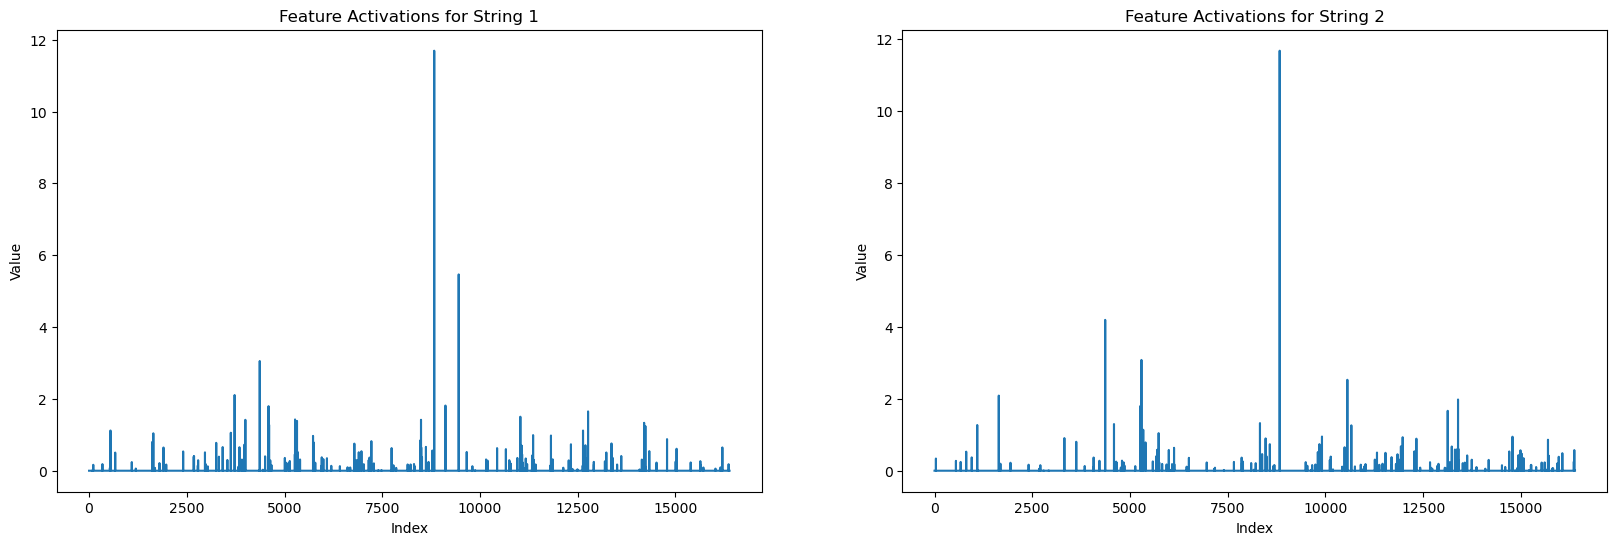

<Figure size 2000x600 with 0 Axes>

Number of overlapped top k features: 25


In [65]:

def process_input_string(input_string):
    embedding = model.get_embedding(input_string)


    sae_output = sae(embedding)
    encoded = sae_output['encoded']
    decoded = sae_output['decoded']
    feature_activations = sae_output['feature_activations']
    
    return encoded, decoded, feature_activations


string1 = "Cookies are yummy. They taste good."
string2 = "I love eating pie! it is so delicious."

encoded1, decoded1, feature_activations1 = process_input_string(string1)
encoded2, decoded2, feature_activations2 = process_input_string(string2)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(feature_activations1.cpu().detach().numpy())
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Activations for String 1')

plt.subplot(1, 2, 2)
plt.plot(feature_activations2.cpu().detach().numpy())
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Activations for String 2')

plt.show()

plt.figure(figsize=(20, 6))

# plt.subplot(1, 2, 1)
# plt.plot(normalized_embedding1.cpu().detach().numpy())
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Normalized Embedding for String 1')

# plt.subplot(1, 2, 2)
# plt.plot(normalized_embedding2.cpu().detach().numpy())
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Normalized Embedding for String 2')

plt.show()


# get the top 50 features for each string
import torch

# Get the indexes of the top 50 features for each string
k = 100
top_k_features1 = torch.topk(feature_activations1, k).indices.cpu().detach().numpy()
top_k_features2 = torch.topk(feature_activations2, k).indices.cpu().detach().numpy()

# print("Top k features for String 1:", top_k_features1)
# print("Top k features for String 2:", top_k_features2)

# Find the intersection of the top k features for both strings
overlapped_features = set(top_k_features1).intersection(set(top_k_features2))

# Get the number of overlapped features
num_overlapped_features = len(overlapped_features)

print("Number of overlapped top k features:", num_overlapped_features)

# dot product of encoded1, encoded1

# normalize both encoded to have l2 norm of 1





In [74]:
def process_input_string(input_string):
    embedding = model.get_embedding(input_string)

    sae_output = sae(embedding)
    encoded = sae_output['encoded']
    decoded = sae_output['decoded']
    feature_activations = sae_output['feature_activations']
    
    return encoded, decoded, feature_activations

string1 = "Cookies are yummy. They taste good."
string2 = "Cars are fast and on roads."

encoded1, decoded1, feature_activations1 = process_input_string(string1)
encoded2, decoded2, feature_activations2 = process_input_string(string2)

# Compute cosine similarity
cos_sim = F.cosine_similarity(encoded1.unsqueeze(0), encoded2.unsqueeze(0))

print("Cosine Similarity:", cos_sim.item())

Cosine Similarity: 0.7280566692352295


In [ ]:
[10899, 12679, 14729, 3710, 5641, 8889, 13827, 5018, 5451, 41]
